In [1]:
import numpy as np
import pandas
import torch
import neuralnetworks_torch as nntorch
import os
import time
import matplotlib.pyplot as plt
import sklearn
from sklearn import metrics
from sklearn.metrics import ConfusionMatrixDisplay
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import scipy
from scipy.spatial.distance import cosine as cos_dist

In [2]:
class CNN1D(torch.nn.Module):

    def __init__(self, n_inputs, n_channels, n_hiddens_per_conv_layer, n_hiddens_per_fc_layer, n_outputs,
                 patch_size_per_conv_layer, stride_per_conv_layer, activation_function='tanh', device='cpu'):

        super().__init__()

        self.device = device

        n_conv_layers = len(n_hiddens_per_conv_layer)
        if (len(patch_size_per_conv_layer) != n_conv_layers
            or len(stride_per_conv_layer) != n_conv_layers):
            raise Exception('The lengths of n_hiddens_per_conv_layer, patch_size_per_conv_layer, and stride_per_conv_layer must be equal.')

        self.activation_function = torch.tanh if activation_function == 'tanh' else torch.relu

        self.make_conv_and_fc_layers(n_inputs, n_channels, n_hiddens_per_conv_layer, n_hiddens_per_fc_layer, n_outputs,
                                     patch_size_per_conv_layer, stride_per_conv_layer)
        
        self.Xmeans = None
        self.to(self.device)

    def make_conv_and_fc_layers(self, n_inputs, n_channels, n_hiddens_per_conv_layer, n_hiddens_per_fc_layer,
                                n_outputs, patch_size_per_conv_layer, stride_per_conv_layer):
        # Create all convolutional layers
        # First argument to first Conv2d is number of channels for each pixel.
        # Just 1 for our grayscale images.
        n_in = n_channels
        input_hw = n_inputs  # original input image height (=width because image assumed square)
        self.conv_layers = torch.nn.ModuleList()
        layeri = 0
        for nh, patch_size, stride in zip(n_hiddens_per_conv_layer,
                                          patch_size_per_conv_layer,
                                          stride_per_conv_layer):
            self.conv_layers.append(torch.nn.Conv1d(n_in, nh, kernel_size=patch_size, stride=stride))
            conv_layer_output_hw = (input_hw - patch_size) // stride + 1
            print(input_hw,patch_size,stride,conv_layer_output_hw)
            if conv_layer_output_hw <= 0:
                raise Exception(f'''For conv layer {layeri}, input_hw of {input_hw} is less than patch_size {patch_size}.
Try reducing the patch_size for this layer or for the previous layer.''')
            input_hw = conv_layer_output_hw  # for next trip through this loop
            n_in = nh
            layeri += 1
           
        # Create all fully connected layers.  First must determine number of inputs to first
        # fully-connected layer that results from flattening the images coming out of the last
        # convolutional layer.
        n_in = input_hw * n_in
        self.fc_layers = torch.nn.ModuleList()
        for nh in n_hiddens_per_fc_layer:
            self.fc_layers.append(torch.nn.Linear(n_in, nh))
            n_in = nh
        self.fc_layers.append(torch.nn.Linear(n_in, n_outputs))

    def forward_all_outputs(self, X):
        n_samples = X.shape[0]
        Ys = [X]
        for conv_layer in self.conv_layers:
            Ys.append(self.activation_function(conv_layer(Ys[-1])))

        flattened_input = Ys[-1].reshape(n_samples, -1)

        for layeri, fc_layer in enumerate(self.fc_layers[:-1]):
            if layeri == 0:
                Ys.append(self.activation_function(fc_layer(flattened_input)))
            else:
                Ys.append(self.activation_function(fc_layer(Ys[-1])))

        if len(self.fc_layers) == 1:
            # only the output layer
            Ys.append(self.fc_layers[-1](flattened_input))
        else:
            Ys.append(self.fc_layers[-1](Ys[-1]))

        return Ys

    def forward(self, X):
        Ys = self.forward_all_outputs(X)
        return Ys[-1]

    def train(self, X, T, batch_size, n_epochs, learning_rate, method='sgd', verbose=True):
        '''X and T must be numpy arrays'''

        self.classes = np.unique(T)
        T = np.arange(len(self.classes))[np.where(T.reshape(-1, 1) == self.classes)[1]]

        # Set data matrices to torch.tensors
        X = torch.from_numpy(X).float().to(self.device)
        T = torch.from_numpy(T).long().to(self.device)  # required for classification in pytorch

        # Setup standardization parameters
        if self.Xmeans is None:
            self.Xmeans = X.mean(axis=0)
            self.Xstds = X.std(axis=0)
            self.Xstds[self.Xstds == 0] = 1  # So we don't divide by zero when standardizing

        # Standardize X
        X = (X - self.Xmeans) / self.Xstds
        
        X.requires_grad_(True)

        if method == 'sgd':
            optimizer = torch.optim.SGD(self.parameters(), lr=learning_rate, momentum=0.9)
        else:
            optimizer = torch.optim.Adam(self.parameters(), lr=learning_rate)

        CELoss = torch.nn.CrossEntropyLoss(reduction='mean')
        self.error_trace = []

        for epoch in range(n_epochs):

            num_batches = X.shape[0] // batch_size
            loss_sum = 0

            for k in range(num_batches):
                start = k * batch_size
                end = (k + 1) * batch_size
                X_batch = X[start:end, ...]
                T_batch = T[start:end, ...]

                Y = self.forward(X_batch)

                loss = CELoss(Y, T_batch)
                loss.backward()

                # Update parameters
                optimizer.step()
                optimizer.zero_grad()

                loss_sum += loss

            self.error_trace.append(loss_sum / num_batches)

            if verbose and (epoch + 1) % (max(1, n_epochs // 10)) == 0:
                print(f'{method}: Epoch {epoch + 1} Loss {self.error_trace[-1]:.3f}')

        return self

    def softmax(self, Y):
        '''Apply to final layer weighted sum outputs'''
        # Trick to avoid overflow
        maxY = torch.max(Y, axis=1)[0].reshape((-1, 1))
        expY = torch.exp(Y - maxY)
        denom = torch.sum(expY, axis=1).reshape((-1, 1))
        Y = expY / denom
        return Y

    def use(self, X):
        # Set input matrix to torch.tensors
        X = torch.from_numpy(X).float().to(self.device)
        # Standardize X
        X = (X - self.Xmeans) / self.Xstds
        # Calculate output of net for all samples in X
        Y = self.forward(X)
        # Convert output to class probabilities
        probs = self.softmax(Y)
        # For each sample pick highest probability and translate that to class labels
        classes = self.classes[torch.argmax(probs, axis=1).cpu().numpy()].reshape(-1, 1)
        return classes, probs.detach().cpu().numpy()

In [3]:
def pad(data):
    eps = np.unique(data[:,0])
    samples = data
    padded = samples.copy()
    for i in eps:
        count = np.count_nonzero(samples[:,0] == i)
        if count < 10:
            max_idx = np.max(np.where(padded[:,0] == i)[0])
            #print(i,10-count,max_idx)
            for j in range(10-count):
                #print("Inserting %s at %s" % (padded[max_idx][0], max_idx+1+j))
                padded = np.insert(padded,max_idx+1+j,padded[max_idx],axis=0)
                #print(j,padded.shape)
                
    return padded

In [4]:
def make_train_test_data(classes, crop_len, feature_idxs):
    subset = crop_len

    Xtrain = np.vstack([train_data[c][:subset] for c in classes])[:,feature_idxs]
    Ttrain = np.vstack([train_data[c][:subset] for c in classes])[:,1]
    Xtrain = Xtrain.reshape(Xtrain.shape[0],-1)

    Xtest = np.vstack([test_data[c] for c in classes])[:,feature_idxs]
    Ttest = np.vstack([test_data[c] for c in classes])[:,1]

    n_channels = Xtrain.shape[1]
    print(Xtrain.shape,Ttrain.shape,Xtest.shape,Ttest.shape)

    Xtrain = Xtrain.flatten().reshape(-1,int(Xtrain.shape[1]*10)) # group into 10s
    Ttrain = np.max(Ttrain.flatten().reshape(-1,10), axis=1)

    Xtest = Xtest.flatten().reshape(-1,int(Xtest.shape[1]*10))
    Ttest = np.max(Ttest.flatten().reshape(-1,10), axis=1)
    print(Xtrain.shape,Ttrain.shape,Xtest.shape,Ttest.shape)

    Xtrain = Xtrain.reshape(-1,1,n_channels*10)
    Xtest = Xtest.reshape(-1,1,n_channels*10)

    print(Xtrain.shape,Ttrain.shape,Xtest.shape,Ttest.shape)

    return Xtrain,Ttrain,Xtest,Ttest

In [5]:
def train_classifier(X, T, n_classes):
    gpu = True
    device = 'cpu'
    if gpu:
        if not torch.cuda.is_available():
            print("CUDA not available. Defaulting to CPU.")
        else:
            device = 'cuda:0'

    n_channels = X.shape[-1]//10
    cnn1d = CNN1D(n_channels*10, 1, [256, 128], [64, 64], n_classes, [n_channels, 4], [8, 2], device=device)

    n_epochs = 500
    batch_size = 100
    learning_rate = 0.001

    cnn1d.train(X, T, batch_size, n_epochs, learning_rate, method='adam')
    
    return cnn1d

In [6]:
# try some new data
# (load all samples from padded_data because we don't care about a balanced set for testing on new object types)
# 2 = cylinders (3 = capsules; 4 = small cubes)
def compare_classes(model, n_channels, novelty_threshold=20):
    novelty = []
    dissimilarities = []
    for i in range(5):
        new_data_class = i
        Xnew = np.vstack([padded_data[new_data_class]])[:,feature_idxs]
        Xnew = Xnew.flatten().reshape(-1,int(Xnew.shape[1]*10))
        Xnew = Xnew.reshape(-1,1,n_channels*10)

        print("New class:", new_data_class)

        # get most similar class
        classes, _ = model.use(Xnew)
        most_similar_class = int(scipy.stats.mode(classes).mode.item())
        print("Most similar class:", most_similar_class)

        # get embedding vectors of the new samples
        newYs = model.forward_all_outputs(torch.from_numpy(Xnew).float())
        new_logits = newYs[-2].detach().numpy()

        #print(np.var(new_logits, axis=0))
        #print(np.var(new_logits, axis=0).shape)
        #print("New data vector variance:", np.sum(np.var(new_logits, axis=0)))

        # get embedding vectors of the known class samples
        Xsim = np.vstack([padded_data[most_similar_class]])[:,feature_idxs]
        Xsim = Xsim.flatten().reshape(-1,int(Xsim.shape[1]*10))
        Xsim = Xsim.reshape(-1,1,n_channels*10)

        simYs = model.forward_all_outputs(torch.from_numpy(Xsim).float())
        sim_logits = simYs[-2].detach().numpy()

        #print(np.mean(new_logits, axis=0))
        #print(np.mean(sim_logits, axis=0))
        new_mean = np.mean(new_logits, axis=0)
        sim_mean = np.mean(sim_logits, axis=0)
        #print(new_mean-sim_mean)

        new_std = np.std(new_logits, axis=0)
        sim_std = np.std(sim_logits, axis=0)
        #print(sim_variance)

        print("Angle from sim_mean to sim_mean+std:",cos_dist(sim_mean,sim_mean+sim_std))
        #print("Angle from sim_mean to sim_mean-var:",cos_dist(sim_mean,sim_mean-sim_variance))
        print("Angle from sim_mean to new_mean:", cos_dist(sim_mean,new_mean))
        #print("Angle from new_mean to new_mean+std:", cos_dist(new_mean,new_mean+new_std))
        #print("Angle from sim_mean to new_mean+std:", cos_dist(sim_mean,new_mean+new_std))
        #print("Angle from sim_mean to new_mean-std:", cos_dist(sim_mean,new_mean-new_std))
        #min_diff_angle = np.min([cos_dist(sim_mean,new_mean+new_std),cos_dist(sim_mean,new_mean-new_std)])
        #max_diff_angle = np.max([cos_dist(sim_mean,new_mean+new_std),cos_dist(sim_mean,new_mean-new_std)])
        #print("Max angle from sim_mean to new_mean+/-std", max_diff_angle)
        #print("Max angle/angle from sim_mean to sim_mean+std:", max_diff_angle/cos_dist(sim_mean,sim_mean+sim_std))
        print("Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std:",\
              cos_dist(sim_mean,new_mean)/cos_dist(sim_mean,sim_mean+sim_std))
        likely_novel_class = cos_dist(sim_mean,new_mean)/cos_dist(sim_mean,sim_mean+sim_std) > 0
        #print(likely_novel_class)

        outlier_threshold = 1
        z_threshold = 3
        
        new_outliers = []
        for i in range(len(new_logits)):
            if cos_dist(sim_mean,new_logits[i])/cos_dist(sim_mean,sim_mean+sim_std) > outlier_threshold:
                #print(i,cos_dist(sim_mean,new_logits[i])/cos_dist(sim_mean,sim_mean+sim_std))
                new_outliers.append(cos_dist(sim_mean,new_logits[i])/cos_dist(sim_mean,sim_mean+sim_std))
        #print(len(new_outliers))
        #print(np.mean([new_outliers]),np.std([new_outliers]))
        new_outliers_pruned = []
        for i in range(len(new_outliers)):
            if (new_outliers[i]-np.mean([new_outliers]))/np.std([new_outliers]) < z_threshold:
                #print(new_outliers[i])
                new_outliers_pruned.append(new_outliers[i])
        #print(len(new_outliers_pruned))
        #print()
        
        sim_outliers = []
        for i in range(len(sim_logits)):
            if cos_dist(sim_mean,sim_logits[i])/cos_dist(sim_mean,sim_mean+sim_std) > outlier_threshold:
                #print(i,cos_dist(sim_mean,sim_logits[i])/cos_dist(sim_mean,sim_mean+sim_std))
                sim_outliers.append(cos_dist(sim_mean,sim_logits[i])/cos_dist(sim_mean,sim_mean+sim_std))
        #print(len(sim_outliers))
        #print(np.mean([sim_outliers]),np.std([sim_outliers]))
        sim_outliers_pruned = []
        for i in range(len(sim_outliers)):
            if (sim_outliers[i]-np.mean([sim_outliers]))/np.std([sim_outliers]) < z_threshold:
                #print(sim_outliers[i])
                sim_outliers_pruned.append(sim_outliers[i])
        #print(len(sim_outliers_pruned))
                
        #print(np.sum(new_outliers_pruned),np.sum(sim_outliers_pruned))
        outlier_ratio = np.sum(new_outliers_pruned)/np.sum(sim_outliers_pruned) \
              if np.sum(sim_outliers_pruned) > 0 else float('inf')
        print("Outlier ratio:",outlier_ratio)
        likely_novel_class = (outlier_ratio == float('inf')) if likely_novel_class else likely_novel_class
        
        dissimilarity = outlier_ratio*cos_dist(sim_mean,new_mean)/cos_dist(sim_mean,sim_mean+sim_std)*\
        np.sum(sim_outliers_pruned)
        print("Dissimilarity from most similar class:", dissimilarity)

        likely_novel_class = (dissimilarity > novelty_threshold) if not likely_novel_class else likely_novel_class
        print("Likely novel class:",likely_novel_class)
        
        print()
        
        dissimilarities.append(dissimilarity)
        novelty.append(likely_novel_class)
        
    return novelty,dissimilarities

Column key:
* Column 1 is the episode number.
* Column 2 is the theme object;  0 = big cube, 1 = sphere, 2 = cylinder, 3 = capsule, 4 = small cube.
* Column 3 is the destination object.  Always 0 because we were always stacking on a cube.
* Columns 4-6 are the rotation (4 = X; 5 = Y; 6 = Z) of the theme object at the start of the trial, in radians.
* Column 7 is the angle, theta (in radians), between the vertical upright axis in world space (0,1,0), and the normalized intrinsic upward axis of the theme object at the start of the trial.
* Columns 8, 9 are the 2-dimensions of the action that was executed.
* Columns 10-12 are the rotation of the theme object after the action was completed (same convention as 4-6), in radians.
* Column 13 is the theta angle, as in 7, but after action was completed.
* Column 14-16 is the "jitter" force applied to the object after placement (to simulate release)
* Columns 17-19 is the center of the theme object (after action completion)
* Columns 20-22 is the size of the theme object
* Column 23-25 is the observation after action completion. Here I’m using height and center of gravity so it takes up 3 columns
* Column 26 is the reward. With this model, the agent gets -1 for missing the destination object entirely, 9 for touching the destination object but the theme falls off, and up to 1000 for successful stacking (1000 on the first try, -100 for each additional attempt).
* Column 27 is the cumulative reward over the episode.
* Column 28 is the mean reward over the episode.

In [7]:
# load up data
data = {}
data[0] = pandas.read_csv('trial-data/122921-2cubes.csv', header=None)
data[0] = data[0][data[0].iloc[:,1] == 0]

data[1] = pandas.read_csv('trial-data/122921-cube_sphere.csv', header=None)
data[1] = data[1][data[1].iloc[:,1] == 1]

data[2] = pandas.read_csv('trial-data/122921-cube_cylinder.csv', header=None)
data[2] = data[2][data[2].iloc[:,1] == 2]

data[3] = pandas.read_csv('trial-data/122921-cube_capsule.csv', header=None)
data[3] = data[3][data[3].iloc[:,1] == 3]

data[4] = pandas.read_csv('trial-data/122921-bigcube_smallcube.csv', header=None)
data[4] = data[4][data[4].iloc[:,1] == 4]

In [8]:
# pad data
padded_data = {}
padded_data[0] = pad(data[0].to_numpy())
padded_data[1] = pad(data[1].to_numpy())
padded_data[2] = pad(data[2].to_numpy())
padded_data[3] = pad(data[3].to_numpy())
padded_data[4] = pad(data[4].to_numpy())

test_n = 100 # 100 test samples of each class

# split train and test
test_data = {}
test_data[0] = padded_data[0][-test_n:]
test_data[1] = padded_data[1][-test_n:]
test_data[2] = padded_data[2][-test_n:]
test_data[3] = padded_data[3][-test_n:]
test_data[4] = padded_data[4][-test_n:]

crop_len = min([len(padded_data[k]) for k in padded_data])-test_n

print(crop_len)

train_data = {}
train_data[0] = padded_data[0][:crop_len]
train_data[1] = padded_data[1][:crop_len]
train_data[2] = padded_data[2][:crop_len]
train_data[3] = padded_data[3][:crop_len]
train_data[4] = padded_data[4][:crop_len]

for k in train_data:
    print(train_data[k].shape,train_data[k])

900
(900, 28) [[   3.    0.    0. ... 1000. 1000. 1000.]
 [   3.    0.    0. ... 1000. 1000. 1000.]
 [   3.    0.    0. ... 1000. 1000. 1000.]
 ...
 [  92.    0.    0. ... 1000. 1000. 1000.]
 [  92.    0.    0. ... 1000. 1000. 1000.]
 [  92.    0.    0. ... 1000. 1000. 1000.]]
(900, 28) [[ 3.        1.        0.       ...  9.        9.        9.      ]
 [ 3.        1.        0.       ...  9.       18.        9.      ]
 [ 3.        1.        0.       ... -1.       17.        5.666667]
 ...
 [92.        1.        0.       ...  9.       62.        7.75    ]
 [92.        1.        0.       ... -1.       61.        6.777778]
 [92.        1.        0.       ... -1.       60.        6.      ]]
(900, 28) [[   3.    2.    0. ... 1000. 1000. 1000.]
 [   3.    2.    0. ... 1000. 1000. 1000.]
 [   3.    2.    0. ... 1000. 1000. 1000.]
 ...
 [  92.    2.    0. ...  800.  798.  266.]
 [  92.    2.    0. ...  800.  798.  266.]
 [  92.    2.    0. ...  800.  798.  266.]]
(900, 28) [[ 3.        3.     

# A: Given cube and sphere

Test for the ability to infer the existence of cylinder and capsule as distinct classes while not splitting small cube from big cube.

========== Experiment 1 ==========
(1800, 19) (1800,) (200, 19) (200,)
(180, 190) (180,) (20, 190) (20,)
(180, 1, 190) (180,) (20, 1, 190) (20,)

CUDA not available. Defaulting to CPU.
190 19 8 22
22 4 2 10
adam: Epoch 50 Loss 0.001
adam: Epoch 100 Loss 0.001
adam: Epoch 150 Loss 0.000
adam: Epoch 200 Loss 0.000
adam: Epoch 250 Loss 0.000
adam: Epoch 300 Loss 0.000
adam: Epoch 350 Loss 0.000
adam: Epoch 400 Loss 0.000
adam: Epoch 450 Loss 0.000
adam: Epoch 500 Loss 0.000

New class: 0
Most similar class: 0
Angle from sim_mean to sim_mean+std: 0.0011711716651916504
Angle from sim_mean to new_mean: 0.0
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 0.0
Outlier ratio: 1.0
Dissimilarity from most similar class: 0.0
Likely novel class: False

New class: 1
Most similar class: 1
Angle from sim_mean to sim_mean+std: 0.13662505149841309
Angle from sim_mean to new_mean: 0.0
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 0.0
Outlier ratio: 1.0
Dissimila

Outlier ratio: 4.17110926736157
Dissimilarity from most similar class: 0.8720361892749147
Likely novel class: False

========== Experiment 5 ==========
(1800, 19) (1800,) (200, 19) (200,)
(180, 190) (180,) (20, 190) (20,)
(180, 1, 190) (180,) (20, 1, 190) (20,)

CUDA not available. Defaulting to CPU.
190 19 8 22
22 4 2 10
adam: Epoch 50 Loss 0.001
adam: Epoch 100 Loss 0.000
adam: Epoch 150 Loss 0.000
adam: Epoch 200 Loss 0.000
adam: Epoch 250 Loss 0.000
adam: Epoch 300 Loss 0.000
adam: Epoch 350 Loss 0.000
adam: Epoch 400 Loss 0.000
adam: Epoch 450 Loss 0.000
adam: Epoch 500 Loss 0.000

New class: 0
Most similar class: 0
Angle from sim_mean to sim_mean+std: 0.0021915435791015625
Angle from sim_mean to new_mean: 0.0
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 0.0
Outlier ratio: 1.0
Dissimilarity from most similar class: 0.0
Likely novel class: False

New class: 1
Most similar class: 1
Angle from sim_mean to sim_mean+std: 0.006170213222503662
Angle from sim_mean 

Most similar class: 0
Angle from sim_mean to sim_mean+std: 0.0020449161529541016
Angle from sim_mean to new_mean: 4.76837158203125e-07
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 0.00023318176518596245
Outlier ratio: 4.319239314007982
Dissimilarity from most similar class: 0.9784196463031996
Likely novel class: False

========== Experiment 9 ==========
(1800, 19) (1800,) (200, 19) (200,)
(180, 190) (180,) (20, 190) (20,)
(180, 1, 190) (180,) (20, 1, 190) (20,)

CUDA not available. Defaulting to CPU.
190 19 8 22
22 4 2 10
adam: Epoch 50 Loss 0.001
adam: Epoch 100 Loss 0.001
adam: Epoch 150 Loss 0.000
adam: Epoch 200 Loss 0.000
adam: Epoch 250 Loss 0.000
adam: Epoch 300 Loss 0.000
adam: Epoch 350 Loss 0.000
adam: Epoch 400 Loss 0.000
adam: Epoch 450 Loss 0.000
adam: Epoch 500 Loss 0.000

New class: 0
Most similar class: 0
Angle from sim_mean to sim_mean+std: 0.0021486282348632812
Angle from sim_mean to new_mean: 0.0
Angle from sim_mean to new_mean/Angle from sim_

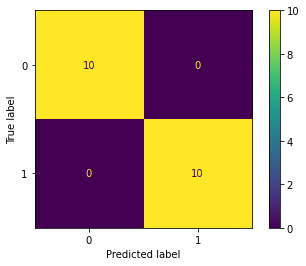

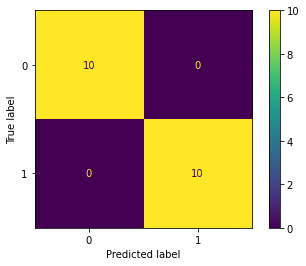

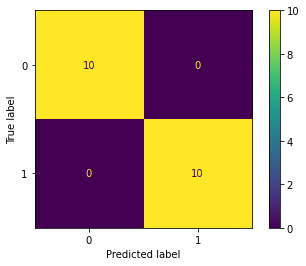

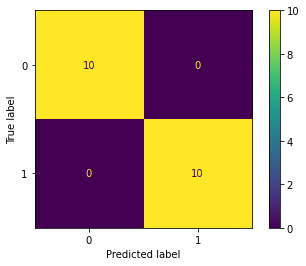

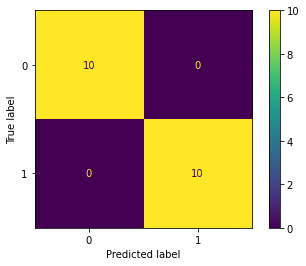

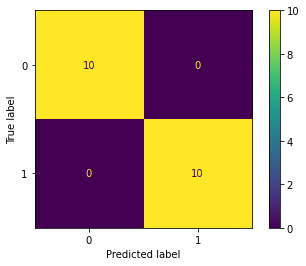

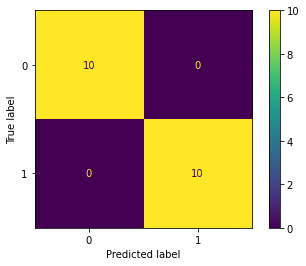

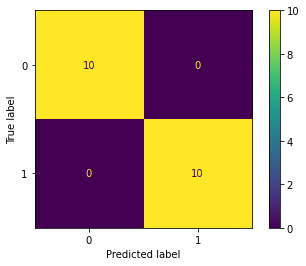

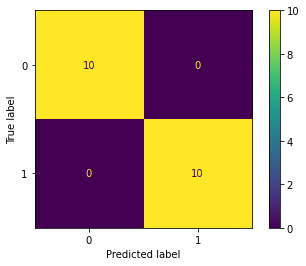

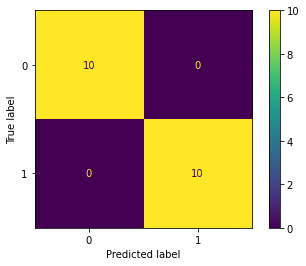

In [13]:
ground_truth = [False, False, True, True, False]
novelty_judgments = []
n_exps = 10

for i in range(n_exps):
    print("========== Experiment %s ==========" % str(i+1))
    
    feature_idxs = [*range(3,16),*range(22,28)] 
    #feature_idxs = [*range(3,13),*range(22,28)] # without jitter force
    #feature_idxs = [*range(3,19),*range(22,28)] # with object position
    Xtrain, Ttrain, Xtest, Ttest = make_train_test_data([0,1], crop_len, feature_idxs)
    print()

    model = train_classifier(Xtrain, Ttrain, 2)
    print()

    # check classifier on the test data
    classes, probs = model.use(Xtest)

    # make confusion matrix
    cm = sklearn.metrics.confusion_matrix(Ttest, classes)
    disp = ConfusionMatrixDisplay(cm)
    disp.plot()

    novel_classes, dissimilarities = compare_classes(model, Xtrain.shape[-1]//10)
    novelty_judgments.append(novel_classes)
    
novelty_judgments = np.array(novelty_judgments).reshape(n_exps,-1).T

pred_acc = []
for i in range(2,len(ground_truth)):
    pred_acc.append(np.sum(novelty_judgments[i] == ground_truth[i])/n_exps)
    print(ground_truth[i], novelty_judgments[i], pred_acc[-1])
    
print(pred_acc, np.mean(pred_acc))

# B: Given cube, sphere, and cylinder

Test for the ability to infer the existence of capsule as a distinct class while not splitting small cube from big cube.

========== Experiment 1 ==========
(2700, 19) (2700,) (300, 19) (300,)
(270, 190) (270,) (30, 190) (30,)
(270, 1, 190) (270,) (30, 1, 190) (30,)

CUDA not available. Defaulting to CPU.
190 19 8 22
22 4 2 10
adam: Epoch 50 Loss 0.063
adam: Epoch 100 Loss 0.034
adam: Epoch 150 Loss 0.007
adam: Epoch 200 Loss 0.002
adam: Epoch 250 Loss 0.001
adam: Epoch 300 Loss 0.001
adam: Epoch 350 Loss 0.001
adam: Epoch 400 Loss 0.000
adam: Epoch 450 Loss 0.000
adam: Epoch 500 Loss 0.000

New class: 0
Most similar class: 0
Angle from sim_mean to sim_mean+std: 0.005786001682281494
Angle from sim_mean to new_mean: 0.0
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 0.0
Outlier ratio: 1.0
Dissimilarity from most similar class: 0.0
Likely novel class: False

New class: 1
Most similar class: 1
Angle from sim_mean to sim_mean+std: 0.0009292364120483398
Angle from sim_mean to new_mean: 0.0
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 0.0
Outlier ratio: 1.0
Dissimil

adam: Epoch 50 Loss 0.054
adam: Epoch 100 Loss 0.016
adam: Epoch 150 Loss 0.005
adam: Epoch 200 Loss 0.002
adam: Epoch 250 Loss 0.001
adam: Epoch 300 Loss 0.001
adam: Epoch 350 Loss 0.001
adam: Epoch 400 Loss 0.001
adam: Epoch 450 Loss 0.000
adam: Epoch 500 Loss 0.000

New class: 0
Most similar class: 0
Angle from sim_mean to sim_mean+std: 0.020637094974517822
Angle from sim_mean to new_mean: 0.0
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 0.0
Outlier ratio: 1.0
Dissimilarity from most similar class: 0.0
Likely novel class: False

New class: 1
Most similar class: 1
Angle from sim_mean to sim_mean+std: 0.004136860370635986
Angle from sim_mean to new_mean: 0.0
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 0.0
Outlier ratio: 1.0
Dissimilarity from most similar class: 0.0
Likely novel class: False

New class: 2
Most similar class: 2
Angle from sim_mean to sim_mean+std: 0.038484036922454834
Angle from sim_mean to new_mean: 0.0
Angle from sim_m

adam: Epoch 50 Loss 0.056
adam: Epoch 100 Loss 0.020
adam: Epoch 150 Loss 0.006
adam: Epoch 200 Loss 0.003
adam: Epoch 250 Loss 0.002
adam: Epoch 300 Loss 0.001
adam: Epoch 350 Loss 0.001
adam: Epoch 400 Loss 0.001
adam: Epoch 450 Loss 0.000
adam: Epoch 500 Loss 0.000

New class: 0
Most similar class: 0
Angle from sim_mean to sim_mean+std: 0.01335841417312622
Angle from sim_mean to new_mean: 0.0
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 0.0
Outlier ratio: 1.0
Dissimilarity from most similar class: 0.0
Likely novel class: False

New class: 1
Most similar class: 1
Angle from sim_mean to sim_mean+std: 0.005407214164733887
Angle from sim_mean to new_mean: 0.0
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 0.0
Outlier ratio: 1.0
Dissimilarity from most similar class: 0.0
Likely novel class: False

New class: 2
Most similar class: 2
Angle from sim_mean to sim_mean+std: 0.019743680953979492
Angle from sim_mean to new_mean: 0.0
Angle from sim_me

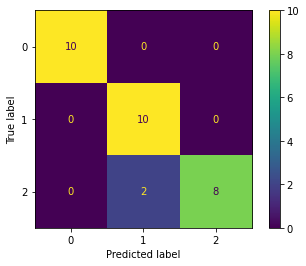

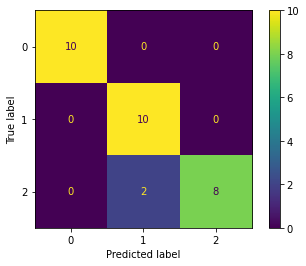

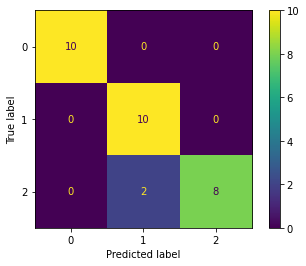

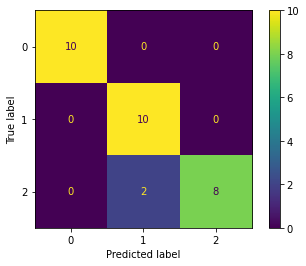

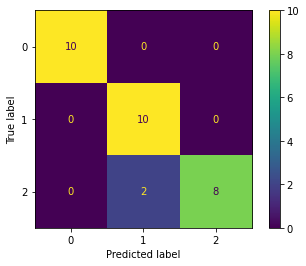

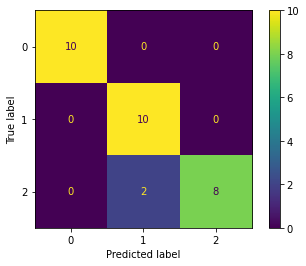

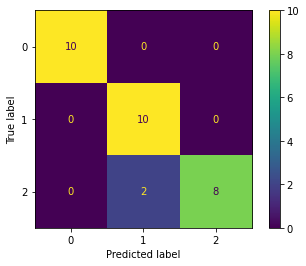

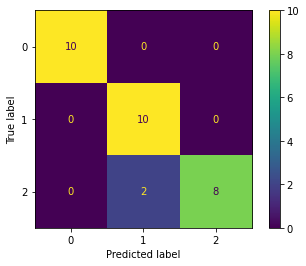

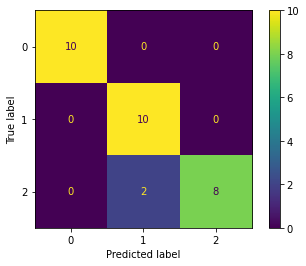

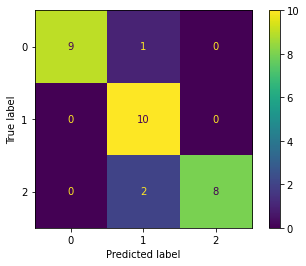

In [14]:
ground_truth = [False, False, False, True, False]
novelty_judgments = []
n_exps = 10

for i in range(n_exps):
    print("========== Experiment %s ==========" % str(i+1))

    feature_idxs = [*range(3,16),*range(22,28)]
    #feature_idxs = [*range(3,13),*range(22,28)] # without jitter force
    #feature_idxs = [*range(3,19),*range(22,28)] # with object position
    Xtrain, Ttrain, Xtest, Ttest = make_train_test_data([0,1,2], crop_len, feature_idxs)
    print()

    model = train_classifier(Xtrain, Ttrain, 3)
    print()

    # check classifier on the test data
    classes, probs = model.use(Xtest)

    # make confusion matrix
    cm = sklearn.metrics.confusion_matrix(Ttest, classes)
    disp = ConfusionMatrixDisplay(cm)
    disp.plot()

    novel_classes, dissimilarities = compare_classes(model, Xtrain.shape[-1]//10)
    novelty_judgments.append(novel_classes)
    
novelty_judgments = np.array(novelty_judgments).reshape(n_exps,-1).T

pred_acc = []
for i in range(2,len(ground_truth)):
    pred_acc.append(np.sum(novelty_judgments[i] == ground_truth[i])/n_exps)
    print(ground_truth[i], novelty_judgments[i], pred_acc[-1])
    
print(pred_acc, np.mean(pred_acc))

# C: Given cube, sphere, and capsule

Test for the ability to infer the existence of cylinder as a distinct class while not splitting small cube from big cube.

========== Experiment 1 ==========
(2700, 19) (2700,) (300, 19) (300,)
(270, 190) (270,) (30, 190) (30,)
(270, 1, 190) (270,) (30, 1, 190) (30,)

CUDA not available. Defaulting to CPU.
190 19 8 22
22 4 2 10
adam: Epoch 50 Loss 0.006
adam: Epoch 100 Loss 0.002
adam: Epoch 150 Loss 0.001
adam: Epoch 200 Loss 0.001
adam: Epoch 250 Loss 0.000
adam: Epoch 300 Loss 0.000
adam: Epoch 350 Loss 0.000
adam: Epoch 400 Loss 0.000
adam: Epoch 450 Loss 0.000
adam: Epoch 500 Loss 0.000

New class: 0
Most similar class: 0
Angle from sim_mean to sim_mean+std: 0.01602804660797119
Angle from sim_mean to new_mean: 0.0
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 0.0
Outlier ratio: 1.0
Dissimilarity from most similar class: 0.0
Likely novel class: False

New class: 1
Most similar class: 1
Angle from sim_mean to sim_mean+std: 0.0001087188720703125
Angle from sim_mean to new_mean: 0.0
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 0.0
Outlier ratio: 1.0
Dissimila

adam: Epoch 50 Loss 0.005
adam: Epoch 100 Loss 0.002
adam: Epoch 150 Loss 0.001
adam: Epoch 200 Loss 0.001
adam: Epoch 250 Loss 0.000
adam: Epoch 300 Loss 0.000
adam: Epoch 350 Loss 0.000
adam: Epoch 400 Loss 0.000
adam: Epoch 450 Loss 0.000
adam: Epoch 500 Loss 0.000

New class: 0
Most similar class: 0
Angle from sim_mean to sim_mean+std: 0.015678048133850098
Angle from sim_mean to new_mean: 0.0
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 0.0
Outlier ratio: 1.0
Dissimilarity from most similar class: 0.0
Likely novel class: False

New class: 1
Most similar class: 1
Angle from sim_mean to sim_mean+std: 1.2874603271484375e-05
Angle from sim_mean to new_mean: 0.0
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 0.0
Outlier ratio: 1.0
Dissimilarity from most similar class: 0.0
Likely novel class: False

New class: 2
Most similar class: 0
Angle from sim_mean to sim_mean+std: 0.015678048133850098
Angle from sim_mean to new_mean: 0.0005583167076110

adam: Epoch 50 Loss 0.007
adam: Epoch 100 Loss 0.002
adam: Epoch 150 Loss 0.001
adam: Epoch 200 Loss 0.001
adam: Epoch 250 Loss 0.000
adam: Epoch 300 Loss 0.000
adam: Epoch 350 Loss 0.000
adam: Epoch 400 Loss 0.000
adam: Epoch 450 Loss 0.000
adam: Epoch 500 Loss 0.000

New class: 0
Most similar class: 0
Angle from sim_mean to sim_mean+std: 0.023949086666107178
Angle from sim_mean to new_mean: 0.0
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 0.0
Outlier ratio: 1.0
Dissimilarity from most similar class: 0.0
Likely novel class: False

New class: 1
Most similar class: 1
Angle from sim_mean to sim_mean+std: 2.396106719970703e-05
Angle from sim_mean to new_mean: 0.0
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 0.0
Outlier ratio: 1.0
Dissimilarity from most similar class: 0.0
Likely novel class: False

New class: 2
Most similar class: 0
Angle from sim_mean to sim_mean+std: 0.023949086666107178
Angle from sim_mean to new_mean: 0.00038135051727294

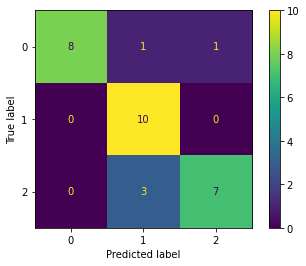

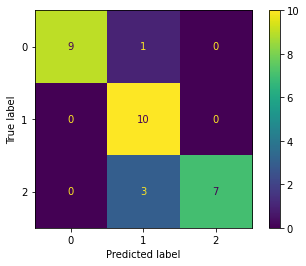

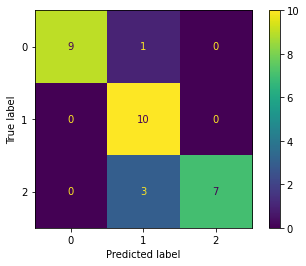

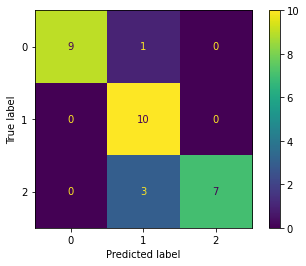

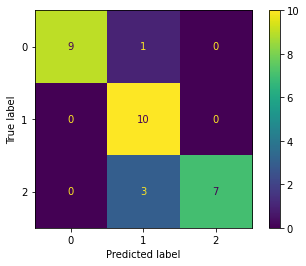

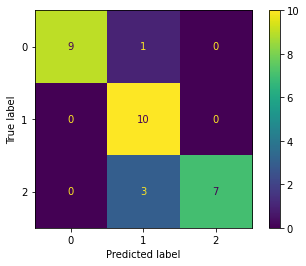

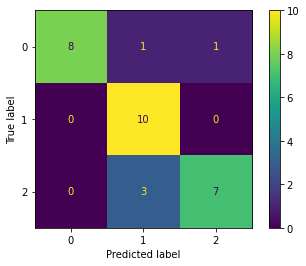

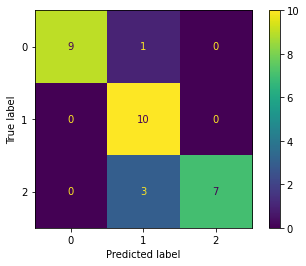

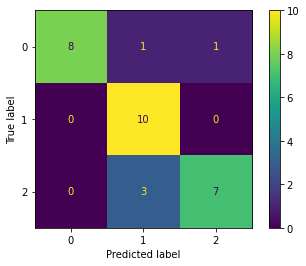

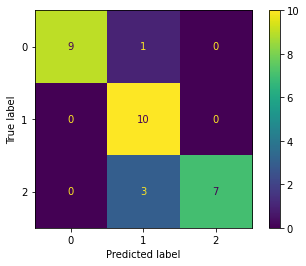

In [15]:
ground_truth = [False, False, True, False, False]
novelty_judgments = []
n_exps = 10

for i in range(n_exps):
    print("========== Experiment %s ==========" % str(i+1))
    
    feature_idxs = [*range(3,16),*range(22,28)]
    #feature_idxs = [*range(3,13),*range(22,28)] # without jitter force
    #feature_idxs = [*range(3,19),*range(22,28)] # with object position
    Xtrain, Ttrain, Xtest, Ttest = make_train_test_data([0,1,3], crop_len, feature_idxs)
    print()

    model = train_classifier(Xtrain, Ttrain, 3)
    print()

    # check classifier on the test data
    classes, probs = model.use(Xtest)

    # make confusion matrix
    cm = sklearn.metrics.confusion_matrix(Ttest, classes)
    disp = ConfusionMatrixDisplay(cm)
    disp.plot()

    novel_classes, dissimilarities = compare_classes(model, Xtrain.shape[-1]//10)
    novelty_judgments.append(novel_classes)
    
novelty_judgments = np.array(novelty_judgments).reshape(n_exps,-1).T

pred_acc = []
for i in range(2,len(ground_truth)):
    pred_acc.append(np.sum(novelty_judgments[i] == ground_truth[i])/n_exps)
    print(ground_truth[i], novelty_judgments[i], pred_acc[-1])
    
print(pred_acc, np.mean(pred_acc))

# D: Given cube, sphere, cylinder, and capsule

Test that small cube is not considered to be different from big cube.

========== Experiment 1 ==========
(3600, 19) (3600,) (400, 19) (400,)
(360, 190) (360,) (40, 190) (40,)
(360, 1, 190) (360,) (40, 1, 190) (40,)

CUDA not available. Defaulting to CPU.
190 19 8 22
22 4 2 10
adam: Epoch 50 Loss 0.028
adam: Epoch 100 Loss 0.007
adam: Epoch 150 Loss 0.003
adam: Epoch 200 Loss 0.002
adam: Epoch 250 Loss 0.001
adam: Epoch 300 Loss 0.001
adam: Epoch 350 Loss 0.001
adam: Epoch 400 Loss 0.001
adam: Epoch 450 Loss 0.001
adam: Epoch 500 Loss 0.000

New class: 0
Most similar class: 0
Angle from sim_mean to sim_mean+std: 0.014889836311340332
Angle from sim_mean to new_mean: 0.0
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 0.0
Outlier ratio: 1.0
Dissimilarity from most similar class: 0.0
Likely novel class: False

New class: 1
Most similar class: 1
Angle from sim_mean to sim_mean+std: 0.0017256736755371094
Angle from sim_mean to new_mean: 0.0
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 0.0
Outlier ratio: 1.0
Dissimil

adam: Epoch 50 Loss 0.028
adam: Epoch 100 Loss 0.008
adam: Epoch 150 Loss 0.004
adam: Epoch 200 Loss 0.002
adam: Epoch 250 Loss 0.001
adam: Epoch 300 Loss 0.001
adam: Epoch 350 Loss 0.001
adam: Epoch 400 Loss 0.001
adam: Epoch 450 Loss 0.001
adam: Epoch 500 Loss 0.000

New class: 0
Most similar class: 0
Angle from sim_mean to sim_mean+std: 0.00782155990600586
Angle from sim_mean to new_mean: 0.0
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 0.0
Outlier ratio: 1.0
Dissimilarity from most similar class: 0.0
Likely novel class: False

New class: 1
Most similar class: 1
Angle from sim_mean to sim_mean+std: 0.0006428360939025879
Angle from sim_mean to new_mean: 0.0
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 0.0
Outlier ratio: 1.0
Dissimilarity from most similar class: 0.0
Likely novel class: False

New class: 2
Most similar class: 2
Angle from sim_mean to sim_mean+std: 0.04368436336517334
Angle from sim_mean to new_mean: 0.0
Angle from sim_me

adam: Epoch 450 Loss 0.001
adam: Epoch 500 Loss 0.000

New class: 0
Most similar class: 0
Angle from sim_mean to sim_mean+std: 0.017011642456054688
Angle from sim_mean to new_mean: 0.0
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 0.0
Outlier ratio: 1.0
Dissimilarity from most similar class: 0.0
Likely novel class: False

New class: 1
Most similar class: 1
Angle from sim_mean to sim_mean+std: 0.0006823539733886719
Angle from sim_mean to new_mean: 0.0
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 0.0
Outlier ratio: 1.0
Dissimilarity from most similar class: 0.0
Likely novel class: False

New class: 2
Most similar class: 2
Angle from sim_mean to sim_mean+std: 0.051052093505859375
Angle from sim_mean to new_mean: 0.0
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 0.0
Outlier ratio: 1.0
Dissimilarity from most similar class: 0.0
Likely novel class: False

New class: 3
Most similar class: 3
Angle from sim_mean to sim_mean+s

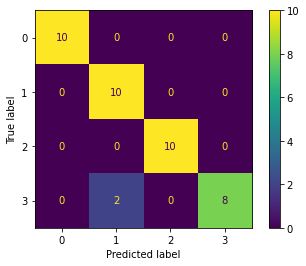

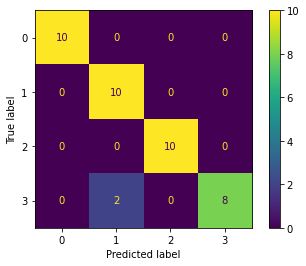

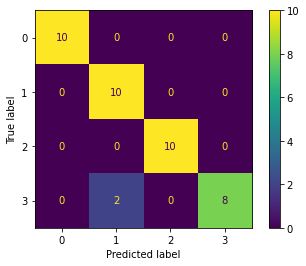

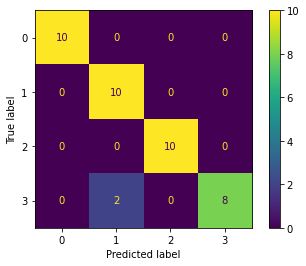

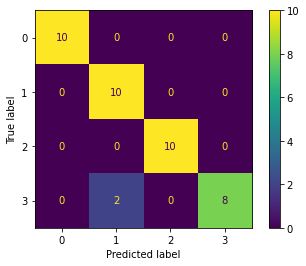

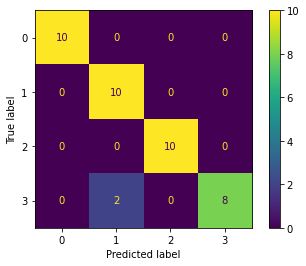

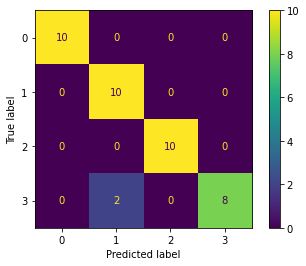

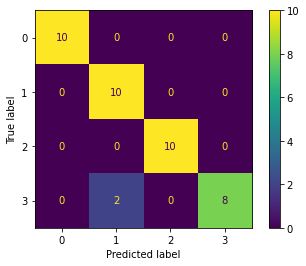

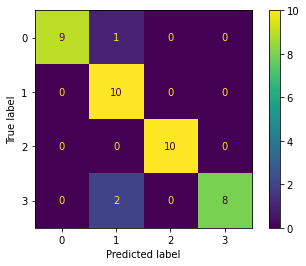

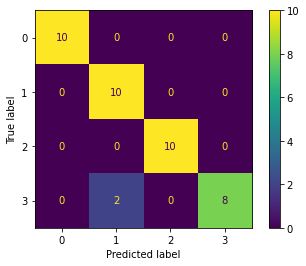

In [16]:
ground_truth = [False, False, False, False, False]
novelty_judgments = []
n_exps = 10

for i in range(n_exps):
    print("========== Experiment %s ==========" % str(i+1))
    
    feature_idxs = [*range(3,16),*range(22,28)]
    #feature_idxs = [*range(3,13),*range(22,28)] # without jitter force
    #feature_idxs = [*range(3,19),*range(22,28)] # with object position
    Xtrain, Ttrain, Xtest, Ttest = make_train_test_data([0,1,2,3], crop_len, feature_idxs)
    print()

    model = train_classifier(Xtrain, Ttrain, 4)
    print()

    # check classifier on the test data
    classes, probs = model.use(Xtest)

    # make confusion matrix
    cm = sklearn.metrics.confusion_matrix(Ttest, classes)
    disp = ConfusionMatrixDisplay(cm)
    disp.plot()

    novel_classes, dissimilarities = compare_classes(model, Xtrain.shape[-1]//10)
    novelty_judgments.append(novel_classes)
    
novelty_judgments = np.array(novelty_judgments).reshape(n_exps,-1).T

pred_acc = []
for i in range(2,len(ground_truth)):
    pred_acc.append(np.sum(novelty_judgments[i] == ground_truth[i])/n_exps)
    print(ground_truth[i], novelty_judgments[i], pred_acc[-1])
    
print(pred_acc, np.mean(pred_acc))

# E: Curriculum learning 1

Start with cube and sphere.  After each trial add the class that has inferred to have the *lowest*  dissimilarity from its most similar class *above the novelty threshold*.  Test for the ability to acquire cylinder and capsule as distinct classes while not splitting small cube from big cube.

========== Experiment 1 ==========
Known classes: [0, 1]
(1800, 19) (1800,) (200, 19) (200,)
(180, 190) (180,) (20, 190) (20,)
(180, 1, 190) (180,) (20, 1, 190) (20,)

CUDA not available. Defaulting to CPU.
190 19 8 22
22 4 2 10
adam: Epoch 50 Loss 0.002
adam: Epoch 100 Loss 0.001
adam: Epoch 150 Loss 0.000
adam: Epoch 200 Loss 0.000
adam: Epoch 250 Loss 0.000
adam: Epoch 300 Loss 0.000
adam: Epoch 350 Loss 0.000
adam: Epoch 400 Loss 0.000
adam: Epoch 450 Loss 0.000
adam: Epoch 500 Loss 0.000

New class: 0
Most similar class: 0
Angle from sim_mean to sim_mean+std: 0.0023161768913269043
Angle from sim_mean to new_mean: 0.0
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 0.0
Outlier ratio: 1.0
Dissimilarity from most similar class: 0.0
Likely novel class: False

New class: 1
Most similar class: 1
Angle from sim_mean to sim_mean+std: 0.0025767087936401367
Angle from sim_mean to new_mean: 0.0
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 0.0
Outl

adam: Epoch 50 Loss 0.056
adam: Epoch 100 Loss 0.025
adam: Epoch 150 Loss 0.005
adam: Epoch 200 Loss 0.002
adam: Epoch 250 Loss 0.001
adam: Epoch 300 Loss 0.001
adam: Epoch 350 Loss 0.001
adam: Epoch 400 Loss 0.000
adam: Epoch 450 Loss 0.000
adam: Epoch 500 Loss 0.000

New class: 0
Most similar class: 0
Angle from sim_mean to sim_mean+std: 0.035008788108825684
Angle from sim_mean to new_mean: 0.0
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 0.0
Outlier ratio: 1.0
Dissimilarity from most similar class: 0.0
Likely novel class: False

New class: 1
Most similar class: 1
Angle from sim_mean to sim_mean+std: 0.005004286766052246
Angle from sim_mean to new_mean: 0.0
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 0.0
Outlier ratio: 1.0
Dissimilarity from most similar class: 0.0
Likely novel class: False

New class: 2
Most similar class: 2
Angle from sim_mean to sim_mean+std: 0.05219089984893799
Angle from sim_mean to new_mean: 0.0
Angle from sim_me

adam: Epoch 50 Loss 0.027
adam: Epoch 100 Loss 0.008
adam: Epoch 150 Loss 0.004
adam: Epoch 200 Loss 0.002
adam: Epoch 250 Loss 0.002
adam: Epoch 300 Loss 0.001
adam: Epoch 350 Loss 0.001
adam: Epoch 400 Loss 0.001
adam: Epoch 450 Loss 0.001
adam: Epoch 500 Loss 0.000

New class: 0
Most similar class: 0
Angle from sim_mean to sim_mean+std: 0.004708826541900635
Angle from sim_mean to new_mean: 0.0
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 0.0
Outlier ratio: 1.0
Dissimilarity from most similar class: 0.0
Likely novel class: False

New class: 1
Most similar class: 1
Angle from sim_mean to sim_mean+std: 0.0005127191543579102
Angle from sim_mean to new_mean: 0.0
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 0.0
Outlier ratio: 1.0
Dissimilarity from most similar class: 0.0
Likely novel class: False

New class: 2
Most similar class: 2
Angle from sim_mean to sim_mean+std: 0.02799898386001587
Angle from sim_mean to new_mean: 0.0
Angle from sim_m

adam: Epoch 50 Loss 0.001
adam: Epoch 100 Loss 0.001
adam: Epoch 150 Loss 0.000
adam: Epoch 200 Loss 0.000
adam: Epoch 250 Loss 0.000
adam: Epoch 300 Loss 0.000
adam: Epoch 350 Loss 0.000
adam: Epoch 400 Loss 0.000
adam: Epoch 450 Loss 0.000
adam: Epoch 500 Loss 0.000

New class: 0
Most similar class: 0
Angle from sim_mean to sim_mean+std: 0.0013157129287719727
Angle from sim_mean to new_mean: 0.0
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 0.0
Outlier ratio: 1.0
Dissimilarity from most similar class: 0.0
Likely novel class: False

New class: 1
Most similar class: 1
Angle from sim_mean to sim_mean+std: 0.11034804582595825
Angle from sim_mean to new_mean: 0.0
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 0.0
Outlier ratio: 1.0
Dissimilarity from most similar class: 0.0
Likely novel class: False

New class: 2
Most similar class: 0
Angle from sim_mean to sim_mean+std: 0.0013157129287719727
Angle from sim_mean to new_mean: 2.1219253540039062e

adam: Epoch 50 Loss 0.008
adam: Epoch 100 Loss 0.002
adam: Epoch 150 Loss 0.001
adam: Epoch 200 Loss 0.001
adam: Epoch 250 Loss 0.001
adam: Epoch 300 Loss 0.000
adam: Epoch 350 Loss 0.000
adam: Epoch 400 Loss 0.000
adam: Epoch 450 Loss 0.000
adam: Epoch 500 Loss 0.000

New class: 0
Most similar class: 0
Angle from sim_mean to sim_mean+std: 0.017578423023223877
Angle from sim_mean to new_mean: 0.0
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 0.0
Outlier ratio: 1.0
Dissimilarity from most similar class: 0.0
Likely novel class: False

New class: 1
Most similar class: 1
Angle from sim_mean to sim_mean+std: 1.615285873413086e-05
Angle from sim_mean to new_mean: 0.0
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 0.0
Outlier ratio: 1.0
Dissimilarity from most similar class: 0.0
Likely novel class: False

New class: 2
Most similar class: 0
Angle from sim_mean to sim_mean+std: 0.017578423023223877
Angle from sim_mean to new_mean: 0.00040400028228759

/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:99: RuntimeWarning: invalid value encountered in double_scalars


Most similar class: 0
Angle from sim_mean to sim_mean+std: 0.0022473931312561035
Angle from sim_mean to new_mean: 8.64267349243164e-06
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 0.003845643813817796
Outlier ratio: 16.65729539142268
Dissimilarity from most similar class: 56.996637310343466
Likely novel class: True

New class: 3
Most similar class: 1
Angle from sim_mean to sim_mean+std: 0.0029543638229370117
Angle from sim_mean to new_mean: 0.006755232810974121
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 2.286527054835976
Outlier ratio: inf
Dissimilarity from most similar class: nan
Likely novel class: True

New class: 4
Most similar class: 0


/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:100: RuntimeWarning: invalid value encountered in double_scalars


Angle from sim_mean to sim_mean+std: 0.0022473931312561035
Angle from sim_mean to new_mean: 2.980232238769531e-07
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 0.00013260840737302744
Outlier ratio: 4.881798737581381
Dissimilarity from most similar class: 0.5760054855320288
Likely novel class: False

Most novel class: 2

Known classes: [0, 1, 2]
(2700, 19) (2700,) (300, 19) (300,)
(270, 190) (270,) (30, 190) (30,)
(270, 1, 190) (270,) (30, 1, 190) (30,)

CUDA not available. Defaulting to CPU.
190 19 8 22
22 4 2 10
adam: Epoch 50 Loss 0.058
adam: Epoch 100 Loss 0.011
adam: Epoch 150 Loss 0.003
adam: Epoch 200 Loss 0.001
adam: Epoch 250 Loss 0.001
adam: Epoch 300 Loss 0.001
adam: Epoch 350 Loss 0.000
adam: Epoch 400 Loss 0.000
adam: Epoch 450 Loss 0.000
adam: Epoch 500 Loss 0.000

New class: 0
Most similar class: 0
Angle from sim_mean to sim_mean+std: 0.006376028060913086
Angle from sim_mean to new_mean: 0.0
Angle from sim_mean to new_mean/Angle from sim_mean to sim

/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/sklearn/metrics/_plot/confusion_matrix.py:114: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


Angle from sim_mean to sim_mean+std: 0.02185344696044922
Angle from sim_mean to new_mean: 0.0
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 0.0
Outlier ratio: 1.0
Dissimilarity from most similar class: 0.0
Likely novel class: False

New class: 1
Most similar class: 1
Angle from sim_mean to sim_mean+std: 0.001733243465423584
Angle from sim_mean to new_mean: 0.0
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 0.0
Outlier ratio: 1.0
Dissimilarity from most similar class: 0.0
Likely novel class: False

New class: 2
Most similar class: 2
Angle from sim_mean to sim_mean+std: 0.06570327281951904
Angle from sim_mean to new_mean: 0.0
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 0.0
Outlier ratio: 1.0
Dissimilarity from most similar class: 0.0
Likely novel class: False

New class: 3
Most similar class: 3
Angle from sim_mean to sim_mean+std: 0.27811509370803833
Angle from sim_mean to new_mean: 0.0
Angle from sim_mean to new_mean/

adam: Epoch 50 Loss 0.001
adam: Epoch 100 Loss 0.001
adam: Epoch 150 Loss 0.000
adam: Epoch 200 Loss 0.000
adam: Epoch 250 Loss 0.000
adam: Epoch 300 Loss 0.000
adam: Epoch 350 Loss 0.000
adam: Epoch 400 Loss 0.000
adam: Epoch 450 Loss 0.000
adam: Epoch 500 Loss 0.000

New class: 0
Most similar class: 0
Angle from sim_mean to sim_mean+std: 0.002328217029571533
Angle from sim_mean to new_mean: 0.0
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 0.0
Outlier ratio: 1.0
Dissimilarity from most similar class: 0.0
Likely novel class: False

New class: 1
Most similar class: 1
Angle from sim_mean to sim_mean+std: 0.015705645084381104
Angle from sim_mean to new_mean: 0.0
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 0.0
Outlier ratio: 1.0
Dissimilarity from most similar class: 0.0
Likely novel class: False

New class: 2
Most similar class: 0
Angle from sim_mean to sim_mean+std: 0.002328217029571533
Angle from sim_mean to new_mean: 1.1622905731201172e-

adam: Epoch 50 Loss 0.007
adam: Epoch 100 Loss 0.002
adam: Epoch 150 Loss 0.001
adam: Epoch 200 Loss 0.001
adam: Epoch 250 Loss 0.001
adam: Epoch 300 Loss 0.000
adam: Epoch 350 Loss 0.000
adam: Epoch 400 Loss 0.000
adam: Epoch 450 Loss 0.000
adam: Epoch 500 Loss 0.000

New class: 0
Most similar class: 0
Angle from sim_mean to sim_mean+std: 0.017716825008392334
Angle from sim_mean to new_mean: 0.0
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 0.0
Outlier ratio: 1.0
Dissimilarity from most similar class: 0.0
Likely novel class: False

New class: 1
Most similar class: 1
Angle from sim_mean to sim_mean+std: 7.152557373046875e-06
Angle from sim_mean to new_mean: 0.0
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 0.0
Outlier ratio: 1.0
Dissimilarity from most similar class: 0.0
Likely novel class: False

New class: 2
Most similar class: 0
Angle from sim_mean to sim_mean+std: 0.017716825008392334
Angle from sim_mean to new_mean: 0.00041913986206054

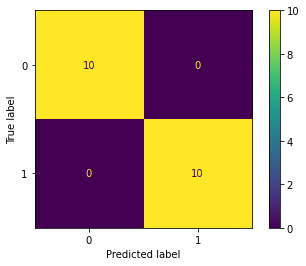

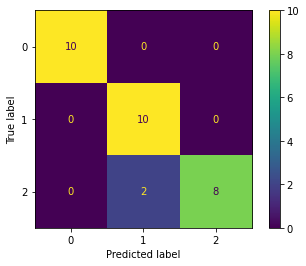

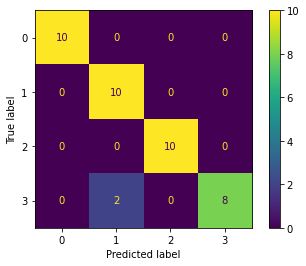

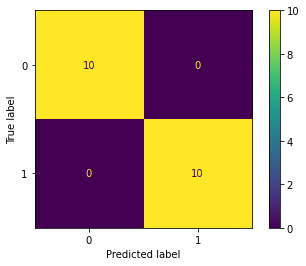

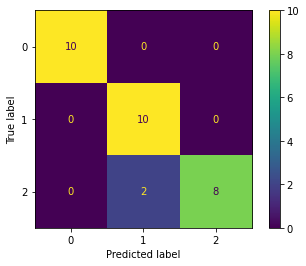

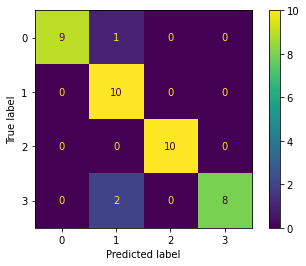

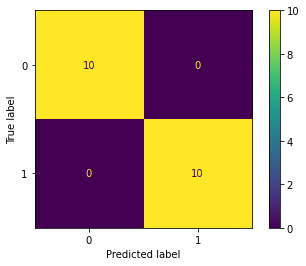

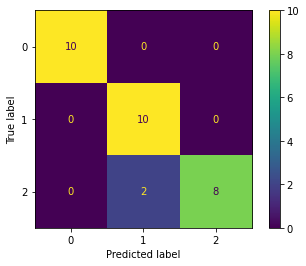

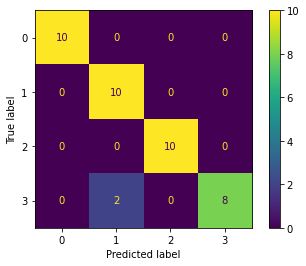

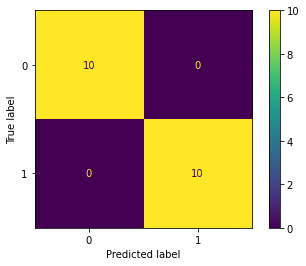

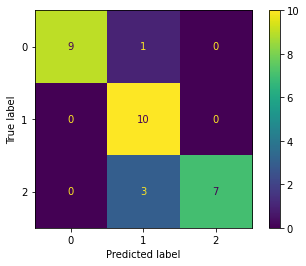

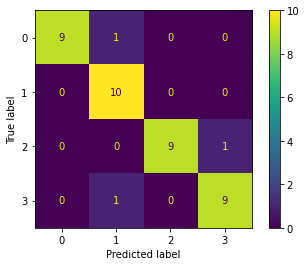

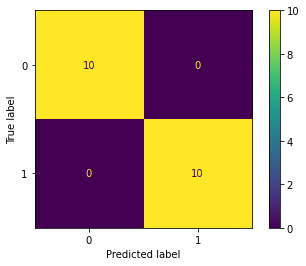

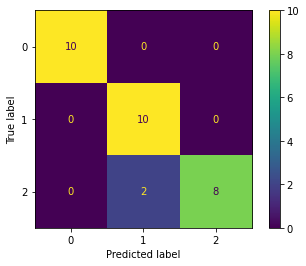

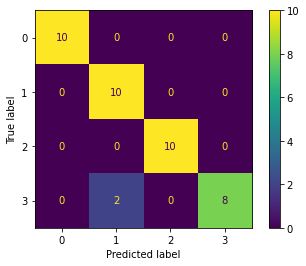

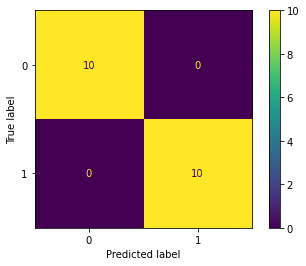

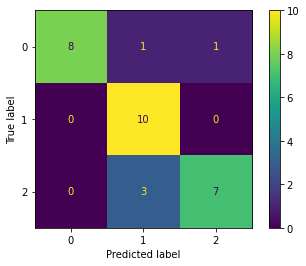

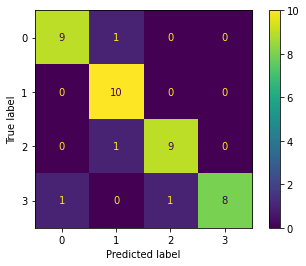

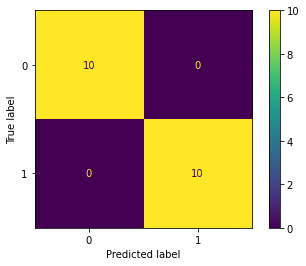

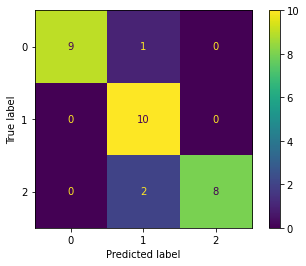

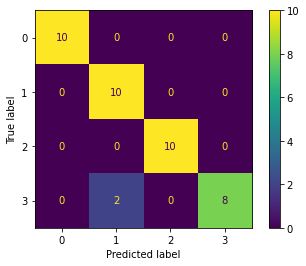

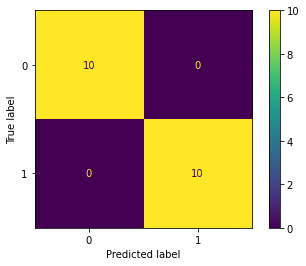

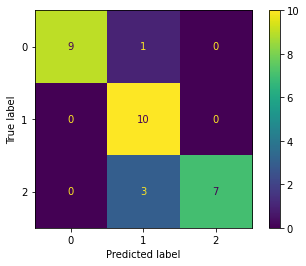

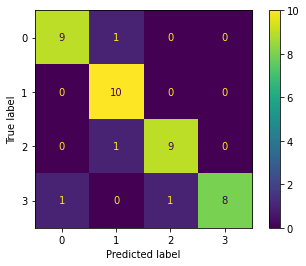

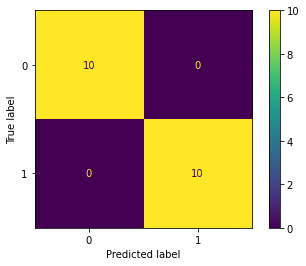

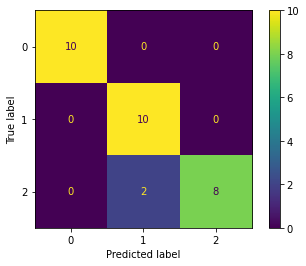

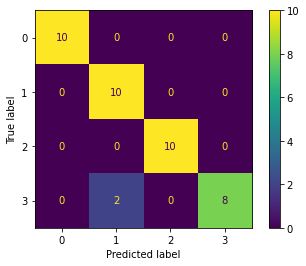

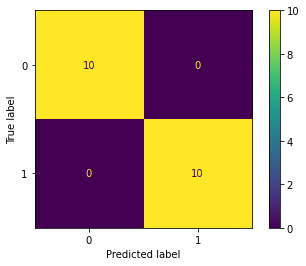

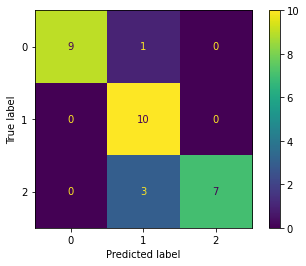

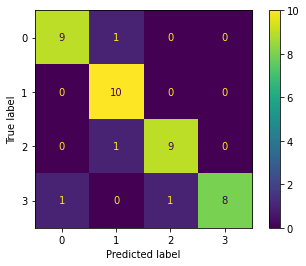

In [17]:
n_exps = 10

ground_truth = [0,1,2,3]

pred_iou = []
for i in range(n_exps):
    print("========== Experiment %s ==========" % str(i+1))
    known_classes = [0,1]
    known_classes_order = []
    
    retrains = 0
    while len(known_classes) < len(ground_truth) and retrains < 5:
        print("Known classes:", known_classes)
        known_classes_order.append(known_classes.copy())
        
        feature_idxs = [*range(3,16),*range(22,28)]
        #feature_idxs = [*range(3,13),*range(22,28)] # without jitter force
        #feature_idxs = [*range(3,19),*range(22,28)] # with object position
        Xtrain, Ttrain, Xtest, Ttest = make_train_test_data(known_classes, crop_len, feature_idxs)
        print()

        model = train_classifier(Xtrain, Ttrain, len(known_classes))
        print()

        # check classifier on the test data
        classes, probs = model.use(Xtest)

        # make confusion matrix
        cm = sklearn.metrics.confusion_matrix(Ttest, classes)
        disp = ConfusionMatrixDisplay(cm)
        disp.plot()

        novel_classes, dissimilarities = compare_classes(model, Xtrain.shape[-1]//10)
        gated_dissimilarities = [dissimilarities[i] if novel_classes[i] == True \
            else float('inf') for i in range(len(dissimilarities))]
        
        gated_dissimilarities = [gated_dissimilarities[i] if gated_dissimilarities[i] == gated_dissimilarities[i] \
            else float('inf') for i in range(len(gated_dissimilarities))]
        
        if np.min(gated_dissimilarities) == float('inf'):
            print("No novel class found")
            retrains += 1
            print("Retraining (%s)" % retrains)
        else:
            new_class = np.argmin(gated_dissimilarities)
            known_classes.append(new_class)
            retrains = 0

            print("Most novel class:", known_classes[-1])
        print()
        
    print("Known classes:", known_classes)
    known_classes_order.append(known_classes.copy())
    
    feature_idxs = [*range(3,16),*range(22,28)]
    #feature_idxs = [*range(3,13),*range(22,28)] # without jitter force
    #feature_idxs = [*range(3,19),*range(22,28)] # with object position
    Xtrain, Ttrain, Xtest, Ttest = make_train_test_data(known_classes, crop_len, feature_idxs)
    print()

    model = train_classifier(Xtrain, Ttrain, len(known_classes))
    print()

    # check classifier on the test data
    classes, probs = model.use(Xtest)

    # make confusion matrix
    cm = sklearn.metrics.confusion_matrix(Ttest, classes)
    disp = ConfusionMatrixDisplay(cm)
    disp.plot()

    novel_classes, dissimilarities = compare_classes(model, Xtrain.shape[-1]//10)
    gated_dissimilarities = [dissimilarities[i] if novel_classes[i] == True \
        else float('inf') for i in range(len(dissimilarities))]
    
    gated_dissimilarities = [gated_dissimilarities[i] if gated_dissimilarities[i] == gated_dissimilarities[i] \
        else float('inf') for i in range(len(gated_dissimilarities))]
    
    if np.min(gated_dissimilarities) != float('inf'):
        new_class = np.argmin(gated_dissimilarities)
        known_classes.append(new_class)
        
    print("Known classes:", known_classes)
    known_classes_order.append(known_classes.copy())
    
    print("Order of acquisition:", known_classes_order)

    pred_iou.append(np.intersect1d(known_classes[2:],ground_truth[2:]).shape[0]/\
                    np.union1d(known_classes[2:],ground_truth[2:]).shape[0])
    print(pred_iou,pred_iou[-1])
    
print(np.sum(pred_iou)/len(pred_iou))

# F: Curriculum learning 2

Start with cube and sphere.  After each trial add the class that has inferred to have the *greatest*  dissimilarity from its most similar class above the novelty threshold.  Test for the ability to acquire cylinder and capsule as distinct classes while not splitting small cube from big cube.

========== Experiment 1 ==========
Known classes: [0, 1]
(1800, 19) (1800,) (200, 19) (200,)
(180, 190) (180,) (20, 190) (20,)
(180, 1, 190) (180,) (20, 1, 190) (20,)

CUDA not available. Defaulting to CPU.
190 19 8 22
22 4 2 10
adam: Epoch 50 Loss 0.001
adam: Epoch 100 Loss 0.001
adam: Epoch 150 Loss 0.000
adam: Epoch 200 Loss 0.000
adam: Epoch 250 Loss 0.000
adam: Epoch 300 Loss 0.000
adam: Epoch 350 Loss 0.000
adam: Epoch 400 Loss 0.000
adam: Epoch 450 Loss 0.000
adam: Epoch 500 Loss 0.000

New class: 0
Most similar class: 0
Angle from sim_mean to sim_mean+std: 0.0016766190528869629
Angle from sim_mean to new_mean: 0.0
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 0.0
Outlier ratio: 1.0
Dissimilarity from most similar class: 0.0
Likely novel class: False

New class: 1
Most similar class: 1
Angle from sim_mean to sim_mean+std: 0.03351426124572754
Angle from sim_mean to new_mean: 0.0
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 0.0
Outlie

Angle from sim_mean to sim_mean+std: 0.0008682608604431152
Angle from sim_mean to new_mean: 4.76837158203125e-07
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 0.0005491865174709961
Outlier ratio: 4.3007222941669205
Dissimilarity from most similar class: 3.3078708674069177
Likely novel class: False

Most novel class: 2

Known classes: [0, 1, 2]
(2700, 19) (2700,) (300, 19) (300,)
(270, 190) (270,) (30, 190) (30,)
(270, 1, 190) (270,) (30, 1, 190) (30,)

CUDA not available. Defaulting to CPU.
190 19 8 22
22 4 2 10
adam: Epoch 50 Loss 0.062
adam: Epoch 100 Loss 0.039
adam: Epoch 150 Loss 0.011
adam: Epoch 200 Loss 0.003
adam: Epoch 250 Loss 0.002
adam: Epoch 300 Loss 0.001
adam: Epoch 350 Loss 0.001
adam: Epoch 400 Loss 0.001
adam: Epoch 450 Loss 0.001
adam: Epoch 500 Loss 0.000

New class: 0
Most similar class: 0
Angle from sim_mean to sim_mean+std: 0.008556723594665527
Angle from sim_mean to new_mean: 0.0
Angle from sim_mean to new_mean/Angle from sim_mean to sim_

Angle from sim_mean to sim_mean+std: 0.013067007064819336
Angle from sim_mean to new_mean: 0.0002460479736328125
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 0.018829711533198314
Outlier ratio: 2.1469445756682024
Dissimilarity from most similar class: 31.78224738863729
Likely novel class: True

Most novel class: 2

Known classes: [0, 1, 3, 2]
(3600, 19) (3600,) (400, 19) (400,)
(360, 190) (360,) (40, 190) (40,)
(360, 1, 190) (360,) (40, 1, 190) (40,)

CUDA not available. Defaulting to CPU.
190 19 8 22
22 4 2 10
adam: Epoch 50 Loss 0.049
adam: Epoch 100 Loss 0.024
adam: Epoch 150 Loss 0.005
adam: Epoch 200 Loss 0.003
adam: Epoch 250 Loss 0.002
adam: Epoch 300 Loss 0.001
adam: Epoch 350 Loss 0.001
adam: Epoch 400 Loss 0.001
adam: Epoch 450 Loss 0.001
adam: Epoch 500 Loss 0.000

New class: 0
Most similar class: 0
Angle from sim_mean to sim_mean+std: 0.18321049213409424
Angle from sim_mean to new_mean: 0.0
Angle from sim_mean to new_mean/Angle from sim_mean to sim_m

Angle from sim_mean to sim_mean+std: 0.016598820686340332
Angle from sim_mean to new_mean: 0.00029778480529785156
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 0.017940118212308155
Outlier ratio: 2.1546629159331836
Dissimilarity from most similar class: 27.583860929234334
Likely novel class: True

Most novel class: 2

Known classes: [0, 1, 3, 2]
(3600, 19) (3600,) (400, 19) (400,)
(360, 190) (360,) (40, 190) (40,)
(360, 1, 190) (360,) (40, 1, 190) (40,)

CUDA not available. Defaulting to CPU.
190 19 8 22
22 4 2 10
adam: Epoch 50 Loss 0.042
adam: Epoch 100 Loss 0.019
adam: Epoch 150 Loss 0.004
adam: Epoch 200 Loss 0.002
adam: Epoch 250 Loss 0.001
adam: Epoch 300 Loss 0.001
adam: Epoch 350 Loss 0.001
adam: Epoch 400 Loss 0.001
adam: Epoch 450 Loss 0.000
adam: Epoch 500 Loss 0.000

New class: 0
Most similar class: 0
Angle from sim_mean to sim_mean+std: 0.07231259346008301
Angle from sim_mean to new_mean: 0.0
Angle from sim_mean to new_mean/Angle from sim_mean to sim

Angle from sim_mean to sim_mean+std: 0.16994255781173706
Angle from sim_mean to new_mean: 0.00042825937271118164
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 0.0025200242848269286
Outlier ratio: 1.2521399945778056
Dissimilarity from most similar class: 1.634694511862332
Likely novel class: False

Known classes: [0, 1, 3, 2]
Order of acquisition: [[0, 1], [0, 1, 3], [0, 1, 3, 2], [0, 1, 3, 2]]
[1.0, 1.0, 1.0, 1.0, 1.0, 0.6666666666666666, 1.0, 0.6666666666666666, 1.0, 0.6666666666666666, 1.0, 1.0, 1.0, 1.0, 1.0] 1.0
========== Experiment 6 ==========
Known classes: [0, 1]
(1800, 19) (1800,) (200, 19) (200,)
(180, 190) (180,) (20, 190) (20,)
(180, 1, 190) (180,) (20, 1, 190) (20,)

CUDA not available. Defaulting to CPU.
190 19 8 22
22 4 2 10
adam: Epoch 50 Loss 0.001
adam: Epoch 100 Loss 0.001
adam: Epoch 150 Loss 0.000
adam: Epoch 200 Loss 0.000
adam: Epoch 250 Loss 0.000
adam: Epoch 300 Loss 0.000
adam: Epoch 350 Loss 0.000
adam: Epoch 400 Loss 0.000
adam: Epoch

Outlier ratio: 12.134731983821629
Dissimilarity from most similar class: 252.01672952197734
Likely novel class: True

New class: 3
Most similar class: 1
Angle from sim_mean to sim_mean+std: 0.1256699562072754
Angle from sim_mean to new_mean: 0.31664419174194336
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 2.519649097511279
Outlier ratio: 4.7220626932370084
Dissimilarity from most similar class: 600.3425457971456
Likely novel class: True

New class: 4
Most similar class: 0
Angle from sim_mean to sim_mean+std: 0.0011407732963562012
Angle from sim_mean to new_mean: 2.980232238769531e-07
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 0.0002612466691049689
Outlier ratio: 3.5685429377558022
Dissimilarity from most similar class: 1.403641457247161
Likely novel class: False

Most novel class: 3

Known classes: [0, 1, 3]
(2700, 19) (2700,) (300, 19) (300,)
(270, 190) (270,) (30, 190) (30,)
(270, 1, 190) (270,) (30, 1, 190) (30,)

CUDA not available.

/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/sklearn/metrics/_plot/confusion_matrix.py:114: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


Angle from sim_mean to sim_mean+std: 0.03387409448623657
Angle from sim_mean to new_mean: 0.0
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 0.0
Outlier ratio: 1.0
Dissimilarity from most similar class: 0.0
Likely novel class: False

New class: 1
Most similar class: 1
Angle from sim_mean to sim_mean+std: 1.823902130126953e-05
Angle from sim_mean to new_mean: 0.0
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 0.0
Outlier ratio: 1.0
Dissimilarity from most similar class: 0.0
Likely novel class: False

New class: 2
Most similar class: 0
Angle from sim_mean to sim_mean+std: 0.03387409448623657
Angle from sim_mean to new_mean: 0.00037801265716552734
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 0.011159343530765618
Outlier ratio: 3.1162843853639473
Dissimilarity from most similar class: 14.64164907462167
Likely novel class: False

New class: 3
Most similar class: 3
Angle from sim_mean to sim_mean+std: 0.16390681266784668
Ang

adam: Epoch 50 Loss 0.007
adam: Epoch 100 Loss 0.002
adam: Epoch 150 Loss 0.001
adam: Epoch 200 Loss 0.001
adam: Epoch 250 Loss 0.000
adam: Epoch 300 Loss 0.000
adam: Epoch 350 Loss 0.000
adam: Epoch 400 Loss 0.000
adam: Epoch 450 Loss 0.000
adam: Epoch 500 Loss 0.000

New class: 0
Most similar class: 0
Angle from sim_mean to sim_mean+std: 0.02523428201675415
Angle from sim_mean to new_mean: 0.0
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 0.0
Outlier ratio: 1.0
Dissimilarity from most similar class: 0.0
Likely novel class: False

New class: 1
Most similar class: 1
Angle from sim_mean to sim_mean+std: 4.470348358154297e-06
Angle from sim_mean to new_mean: 0.0
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 0.0
Outlier ratio: 1.0
Dissimilarity from most similar class: 0.0
Likely novel class: False

New class: 2
Most similar class: 0
Angle from sim_mean to sim_mean+std: 0.02523428201675415
Angle from sim_mean to new_mean: 0.0004102587699890136

adam: Epoch 50 Loss 0.048
adam: Epoch 100 Loss 0.050
adam: Epoch 150 Loss 0.006
adam: Epoch 200 Loss 0.003
adam: Epoch 250 Loss 0.002
adam: Epoch 300 Loss 0.001
adam: Epoch 350 Loss 0.001
adam: Epoch 400 Loss 0.001
adam: Epoch 450 Loss 0.000
adam: Epoch 500 Loss 0.000

New class: 0
Most similar class: 0
Angle from sim_mean to sim_mean+std: 0.08539539575576782
Angle from sim_mean to new_mean: 0.0
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 0.0
Outlier ratio: 1.0
Dissimilarity from most similar class: 0.0
Likely novel class: False

New class: 1
Most similar class: 1
Angle from sim_mean to sim_mean+std: 0.0013145208358764648
Angle from sim_mean to new_mean: 0.0
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 0.0
Outlier ratio: 1.0
Dissimilarity from most similar class: 0.0
Likely novel class: False

New class: 2
Most similar class: 2
Angle from sim_mean to sim_mean+std: 0.09641361236572266
Angle from sim_mean to new_mean: 0.0
Angle from sim_me

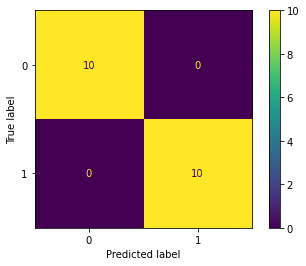

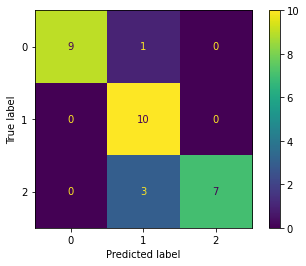

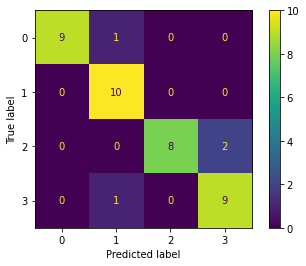

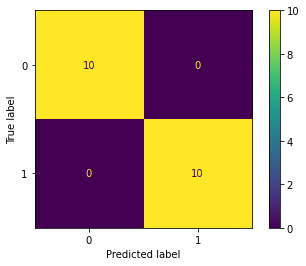

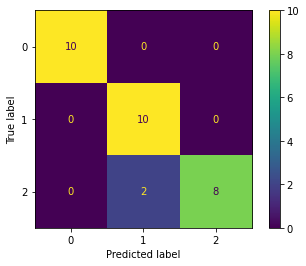

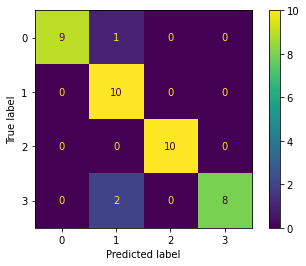

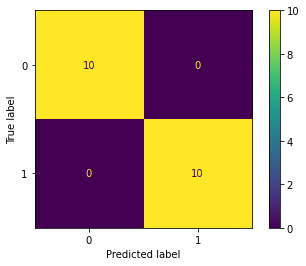

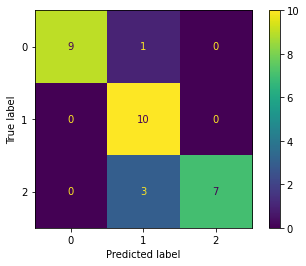

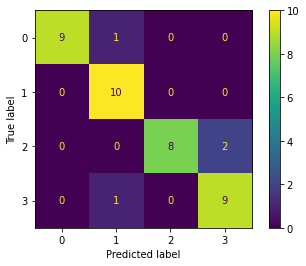

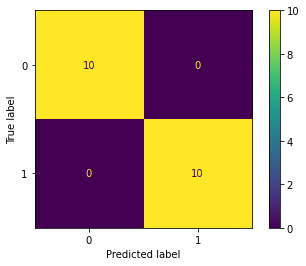

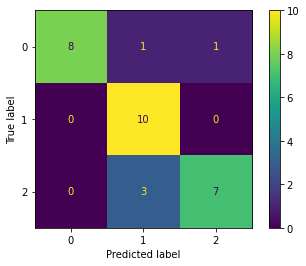

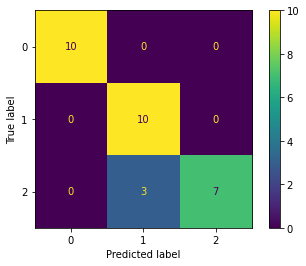

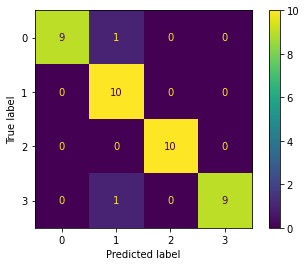

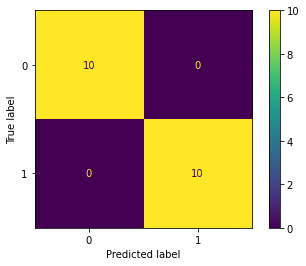

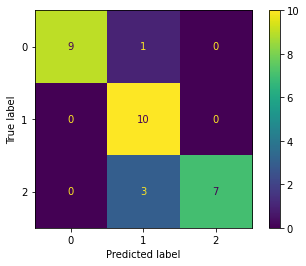

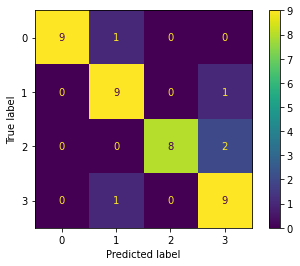

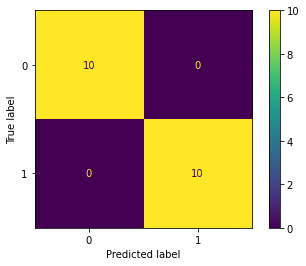

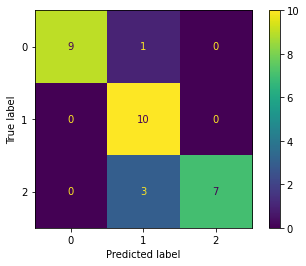

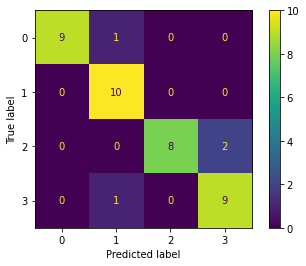

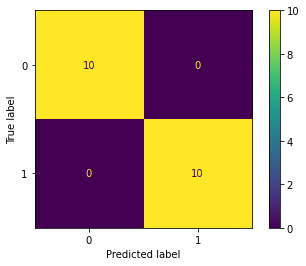

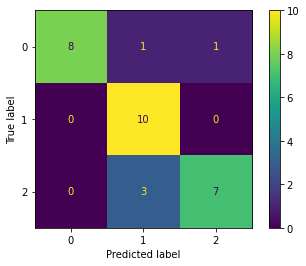

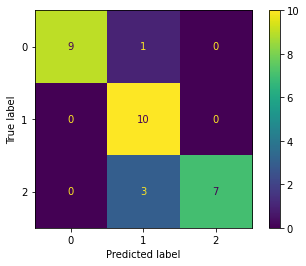

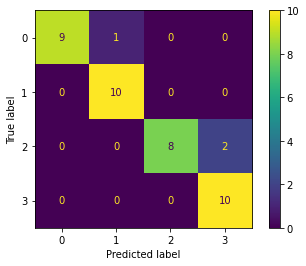

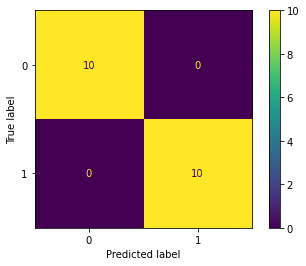

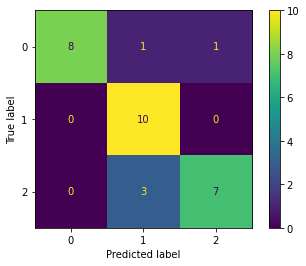

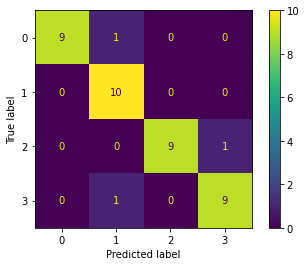

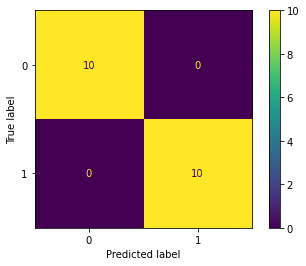

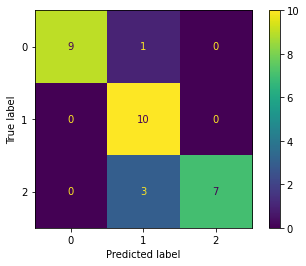

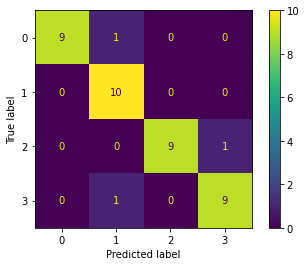

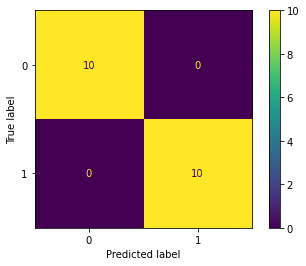

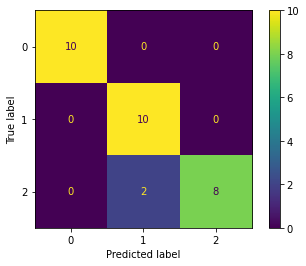

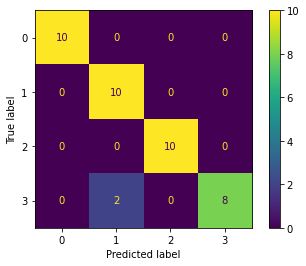

In [18]:
n_exps = 10

ground_truth = [0,1,2,3]

pred_acc = []
for i in range(n_exps):
    print("========== Experiment %s ==========" % str(i+1))
    known_classes = [0,1]
    known_classes_order = []
    
    retrains = 0
    while len(known_classes) < len(ground_truth) and retrains < 5:
        print("Known classes:", known_classes)
        known_classes_order.append(known_classes.copy())
        
        feature_idxs = [*range(3,16),*range(22,28)]
        #feature_idxs = [*range(3,13),*range(22,28)] # without jitter force
        #feature_idxs = [*range(3,19),*range(22,28)] # with object position
        Xtrain, Ttrain, Xtest, Ttest = make_train_test_data(known_classes, crop_len, feature_idxs)
        print()

        model = train_classifier(Xtrain, Ttrain, len(known_classes))
        print()

        # check classifier on the test data
        classes, probs = model.use(Xtest)

        # make confusion matrix
        cm = sklearn.metrics.confusion_matrix(Ttest, classes)
        disp = ConfusionMatrixDisplay(cm)
        disp.plot()

        novel_classes, dissimilarities = compare_classes(model, Xtrain.shape[-1]//10)
        gated_dissimilarities = [dissimilarities[i] if novel_classes[i] == True \
            else float('-inf') for i in range(len(dissimilarities))]
        
        gated_dissimilarities = [gated_dissimilarities[i] if gated_dissimilarities[i] == gated_dissimilarities[i] \
            else float('-inf') for i in range(len(gated_dissimilarities))]
        
        if np.max(gated_dissimilarities) == float('-inf'):
            print("No novel class found")
            retrains += 1
            print("Retraining (%s)" % retrains)
        else:
            new_class = np.argmax(gated_dissimilarities)
            known_classes.append(new_class)
            retrains = 0

            print("Most novel class:", known_classes[-1])
        print()
        
    print("Known classes:", known_classes)
    known_classes_order.append(known_classes.copy())
    
    feature_idxs = [*range(3,16),*range(22,28)]
    #feature_idxs = [*range(3,13),*range(22,28)] # without jitter force
    #feature_idxs = [*range(3,19),*range(22,28)] # with object position
    Xtrain, Ttrain, Xtest, Ttest = make_train_test_data(known_classes, crop_len, feature_idxs)
    print()

    model = train_classifier(Xtrain, Ttrain, len(known_classes))
    print()

    # check classifier on the test data
    classes, probs = model.use(Xtest)

    # make confusion matrix
    cm = sklearn.metrics.confusion_matrix(Ttest, classes)
    disp = ConfusionMatrixDisplay(cm)
    disp.plot()

    novel_classes, dissimilarities = compare_classes(model, Xtrain.shape[-1]//10)
    gated_dissimilarities = [dissimilarities[i] if novel_classes[i] == True \
        else float('-inf') for i in range(len(dissimilarities))]
    
    gated_dissimilarities = [gated_dissimilarities[i] if gated_dissimilarities[i] == gated_dissimilarities[i] \
        else float('-inf') for i in range(len(gated_dissimilarities))]
    
    if np.max(gated_dissimilarities) != float('-inf'):
        new_class = np.argmax(gated_dissimilarities)
        known_classes.append(new_class)
        
    print("Known classes:", known_classes)
    known_classes_order.append(known_classes.copy())
    
    print("Order of acquisition:", known_classes_order)

    pred_iou.append(np.intersect1d(known_classes[2:],ground_truth[2:]).shape[0]/\
                    np.union1d(known_classes[2:],ground_truth[2:]).shape[0])
    print(pred_iou,pred_iou[-1])
    
print(np.sum(pred_iou)/len(pred_iou))

# G: Given cube and sphere (no VoxML features)

Like (A), but the training data drops the VoxML-derived "jitter" features.

========== Experiment 1 ==========
(1800, 16) (1800,) (200, 16) (200,)
(180, 160) (180,) (20, 160) (20,)
(180, 1, 160) (180,) (20, 1, 160) (20,)

CUDA not available. Defaulting to CPU.
160 16 8 19
19 4 2 8
adam: Epoch 50 Loss 0.002
adam: Epoch 100 Loss 0.001
adam: Epoch 150 Loss 0.001
adam: Epoch 200 Loss 0.000
adam: Epoch 250 Loss 0.000
adam: Epoch 300 Loss 0.000
adam: Epoch 350 Loss 0.000
adam: Epoch 400 Loss 0.000
adam: Epoch 450 Loss 0.000
adam: Epoch 500 Loss 0.000

New class: 0
Most similar class: 0
Angle from sim_mean to sim_mean+std: 0.013118863105773926
Angle from sim_mean to new_mean: 0.0
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 0.0
Outlier ratio: 1.0
Dissimilarity from most similar class: 0.0
Likely novel class: False

New class: 1
Most similar class: 1
Angle from sim_mean to sim_mean+std: 0.0
Angle from sim_mean to new_mean: 0.0
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: nan
Outlier ratio: inf
Dissimilarity from most sim

/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in double_scalars
/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:58: RuntimeWarning: invalid value encountered in double_scalars
/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in double_scalars
/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: divide by zero encountered in double_scalars
/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:68: RuntimeWarning: divide by zero encountered in double_scalars
/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:73: RuntimeWarning: invalid value encountered in double_scalars
/Users/n

Angle from sim_mean to sim_mean+std: 0.013118863105773926
Angle from sim_mean to new_mean: 1.4901161193847656e-06
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 0.00011358576634044835
Outlier ratio: 4.802542752037377
Dissimilarity from most similar class: 0.4149056153948481
Likely novel class: False

New class: 3
Most similar class: 1
Angle from sim_mean to sim_mean+std: 0.0
Angle from sim_mean to new_mean: 3.796815872192383e-05
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: inf
Outlier ratio: inf
Dissimilarity from most similar class: nan
Likely novel class: True

New class: 4


/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:57: RuntimeWarning: divide by zero encountered in double_scalars
/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:58: RuntimeWarning: divide by zero encountered in double_scalars
/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:100: RuntimeWarning: invalid value encountered in double_scalars


Most similar class: 0
Angle from sim_mean to sim_mean+std: 0.013118863105773926
Angle from sim_mean to new_mean: 2.980232238769531e-07
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 2.271715326808967e-05
Outlier ratio: 2.199406715563208
Dissimilarity from most similar class: 0.03800262668925481
Likely novel class: False

========== Experiment 2 ==========
(1800, 16) (1800,) (200, 16) (200,)
(180, 160) (180,) (20, 160) (20,)
(180, 1, 160) (180,) (20, 1, 160) (20,)

CUDA not available. Defaulting to CPU.
160 16 8 19
19 4 2 8
adam: Epoch 50 Loss 0.001
adam: Epoch 100 Loss 0.001
adam: Epoch 150 Loss 0.000
adam: Epoch 200 Loss 0.000
adam: Epoch 250 Loss 0.000
adam: Epoch 300 Loss 0.000
adam: Epoch 350 Loss 0.000
adam: Epoch 400 Loss 0.000
adam: Epoch 450 Loss 0.000
adam: Epoch 500 Loss 0.000

New class: 0
Most similar class: 0
Angle from sim_mean to sim_mean+std: 0.0058876872062683105
Angle from sim_mean to new_mean: 0.0
Angle from sim_mean to new_mean/Angle from sim_m

/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in double_scalars
/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:58: RuntimeWarning: invalid value encountered in double_scalars
/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in double_scalars
/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: divide by zero encountered in double_scalars
/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:68: RuntimeWarning: divide by zero encountered in double_scalars
/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:73: RuntimeWarning: invalid value encountered in double_scalars
/Users/n

Angle from sim_mean to sim_mean+std: 0.01247793436050415
Angle from sim_mean to new_mean: 2.6226043701171875e-06
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 0.00021017936898421266
Outlier ratio: 4.874596359907994
Dissimilarity from most similar class: 0.8171139337156408
Likely novel class: False

New class: 3
Most similar class: 1
Angle from sim_mean to sim_mean+std: 0.0
Angle from sim_mean to new_mean: 2.3603439331054688e-05
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: inf
Outlier ratio: inf
Dissimilarity from most similar class: nan
Likely novel class: True

New class: 4
Most similar class: 0


/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:57: RuntimeWarning: divide by zero encountered in double_scalars
/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:58: RuntimeWarning: divide by zero encountered in double_scalars
/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:100: RuntimeWarning: invalid value encountered in double_scalars


Angle from sim_mean to sim_mean+std: 0.01247793436050415
Angle from sim_mean to new_mean: 2.980232238769531e-07
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 2.388401920275144e-05
Outlier ratio: 2.0002584966434402
Dissimilarity from most similar class: 0.038101968020535594
Likely novel class: False

========== Experiment 4 ==========
(1800, 16) (1800,) (200, 16) (200,)
(180, 160) (180,) (20, 160) (20,)
(180, 1, 160) (180,) (20, 1, 160) (20,)

CUDA not available. Defaulting to CPU.
160 16 8 19
19 4 2 8
adam: Epoch 50 Loss 0.002
adam: Epoch 100 Loss 0.001
adam: Epoch 150 Loss 0.000
adam: Epoch 200 Loss 0.000
adam: Epoch 250 Loss 0.000
adam: Epoch 300 Loss 0.000
adam: Epoch 350 Loss 0.000
adam: Epoch 400 Loss 0.000
adam: Epoch 450 Loss 0.000
adam: Epoch 500 Loss 0.000

New class: 0
Most similar class: 0
Angle from sim_mean to sim_mean+std: 0.01418381929397583
Angle from sim_mean to new_mean: 0.0
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 0.

/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in double_scalars
/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:58: RuntimeWarning: invalid value encountered in double_scalars
/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in double_scalars
/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: divide by zero encountered in double_scalars
/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:68: RuntimeWarning: divide by zero encountered in double_scalars
/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:73: RuntimeWarning: invalid value encountered in double_scalars
/Users/n

Angle from sim_mean to sim_mean+std: 0.01418381929397583
Angle from sim_mean to new_mean: 7.450580596923828e-06
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 0.0005252873321706973
Outlier ratio: 4.973065155877642
Dissimilarity from most similar class: 1.8372810752603015
Likely novel class: False

New class: 3
Most similar class: 1
Angle from sim_mean to sim_mean+std: 0.0
Angle from sim_mean to new_mean: 5.060434341430664e-05
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: inf
Outlier ratio: inf
Dissimilarity from most similar class: nan
Likely novel class: True

New class: 4
Most similar class: 0


/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:57: RuntimeWarning: divide by zero encountered in double_scalars
/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:58: RuntimeWarning: divide by zero encountered in double_scalars
/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:100: RuntimeWarning: invalid value encountered in double_scalars


Angle from sim_mean to sim_mean+std: 0.01418381929397583
Angle from sim_mean to new_mean: 5.364418029785156e-07
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 3.782068791629021e-05
Outlier ratio: 2.194438852579408
Dissimilarity from most similar class: 0.05837238424926598
Likely novel class: False

========== Experiment 5 ==========
(1800, 16) (1800,) (200, 16) (200,)
(180, 160) (180,) (20, 160) (20,)
(180, 1, 160) (180,) (20, 1, 160) (20,)

CUDA not available. Defaulting to CPU.
160 16 8 19
19 4 2 8
adam: Epoch 50 Loss 0.001
adam: Epoch 100 Loss 0.000
adam: Epoch 150 Loss 0.000
adam: Epoch 200 Loss 0.000
adam: Epoch 250 Loss 0.000
adam: Epoch 300 Loss 0.000
adam: Epoch 350 Loss 0.000
adam: Epoch 400 Loss 0.000
adam: Epoch 450 Loss 0.000
adam: Epoch 500 Loss 0.000

New class: 0
Most similar class: 0
Angle from sim_mean to sim_mean+std: 0.012864351272583008
Angle from sim_mean to new_mean: 0.0
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 0.0

/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in double_scalars
/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:58: RuntimeWarning: invalid value encountered in double_scalars
/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in double_scalars
/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: divide by zero encountered in double_scalars
/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:68: RuntimeWarning: divide by zero encountered in double_scalars
/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:73: RuntimeWarning: invalid value encountered in double_scalars
/Users/n

Angle from sim_mean to sim_mean+std: 0.012864351272583008
Angle from sim_mean to new_mean: 6.67572021484375e-06
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 0.0005189317419426581
Outlier ratio: 5.108144205019509
Dissimilarity from most similar class: 2.053704622244808
Likely novel class: False

New class: 3
Most similar class: 1
Angle from sim_mean to sim_mean+std: 0.0
Angle from sim_mean to new_mean: 8.279085159301758e-05
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: inf
Outlier ratio: inf
Dissimilarity from most similar class: nan
Likely novel class: True

New class: 4
Most similar class: 0


/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:57: RuntimeWarning: divide by zero encountered in double_scalars
/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:58: RuntimeWarning: divide by zero encountered in double_scalars
/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:100: RuntimeWarning: invalid value encountered in double_scalars


Angle from sim_mean to sim_mean+std: 0.012864351272583008
Angle from sim_mean to new_mean: 1.430511474609375e-06
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 0.00011119965898771244
Outlier ratio: 1.9997055866802271
Dissimilarity from most similar class: 0.17227970143631766
Likely novel class: False

========== Experiment 6 ==========
(1800, 16) (1800,) (200, 16) (200,)
(180, 160) (180,) (20, 160) (20,)
(180, 1, 160) (180,) (20, 1, 160) (20,)

CUDA not available. Defaulting to CPU.
160 16 8 19
19 4 2 8
adam: Epoch 50 Loss 0.002
adam: Epoch 100 Loss 0.001
adam: Epoch 150 Loss 0.000
adam: Epoch 200 Loss 0.000
adam: Epoch 250 Loss 0.000
adam: Epoch 300 Loss 0.000
adam: Epoch 350 Loss 0.000
adam: Epoch 400 Loss 0.000
adam: Epoch 450 Loss 0.000
adam: Epoch 500 Loss 0.000

New class: 0
Most similar class: 0
Angle from sim_mean to sim_mean+std: 0.011144757270812988
Angle from sim_mean to new_mean: 0.0
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 

/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in double_scalars
/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:58: RuntimeWarning: invalid value encountered in double_scalars
/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in double_scalars
/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: divide by zero encountered in double_scalars
/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:68: RuntimeWarning: divide by zero encountered in double_scalars
/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:73: RuntimeWarning: invalid value encountered in double_scalars
/Users/n

Outlier ratio: 4.833698495417427
Dissimilarity from most similar class: 0.5282180895588474
Likely novel class: False

New class: 3
Most similar class: 1
Angle from sim_mean to sim_mean+std: 0.0
Angle from sim_mean to new_mean: 4.1365623474121094e-05
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: inf
Outlier ratio: inf
Dissimilarity from most similar class: nan
Likely novel class: True

New class: 4
Most similar class: 0


/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:57: RuntimeWarning: divide by zero encountered in double_scalars
/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:58: RuntimeWarning: divide by zero encountered in double_scalars
/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:100: RuntimeWarning: invalid value encountered in double_scalars


Angle from sim_mean to sim_mean+std: 0.011144757270812988
Angle from sim_mean to new_mean: 4.76837158203125e-07
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 4.2785782284546845e-05
Outlier ratio: 2.000776031763168
Dissimilarity from most similar class: 0.07604914568797891
Likely novel class: False

========== Experiment 7 ==========
(1800, 16) (1800,) (200, 16) (200,)
(180, 160) (180,) (20, 160) (20,)
(180, 1, 160) (180,) (20, 1, 160) (20,)

CUDA not available. Defaulting to CPU.
160 16 8 19
19 4 2 8
adam: Epoch 50 Loss 0.002
adam: Epoch 100 Loss 0.001
adam: Epoch 150 Loss 0.001
adam: Epoch 200 Loss 0.000
adam: Epoch 250 Loss 0.000
adam: Epoch 300 Loss 0.000
adam: Epoch 350 Loss 0.000
adam: Epoch 400 Loss 0.000
adam: Epoch 450 Loss 0.000
adam: Epoch 500 Loss 0.000

New class: 0
Most similar class: 0
Angle from sim_mean to sim_mean+std: 0.012960970401763916
Angle from sim_mean to new_mean: 0.0
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 0.

Angle from sim_mean to sim_mean+std: 0.01191633939743042
Angle from sim_mean to new_mean: 4.76837158203125e-07
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 4.0015405931283544e-05
Outlier ratio: 1.9926010584899985
Dissimilarity from most similar class: 0.06643013835992988
Likely novel class: False

True [False False False False False False False False False False] 0.0
True [ True  True  True  True  True  True  True  True  True  True] 1.0
False [False False False False False False False False False False] 1.0
[0.0, 1.0, 1.0] 0.6666666666666666


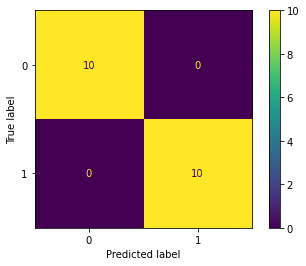

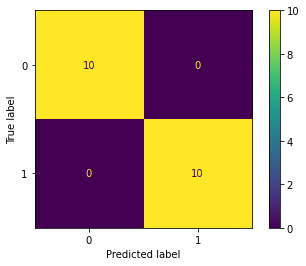

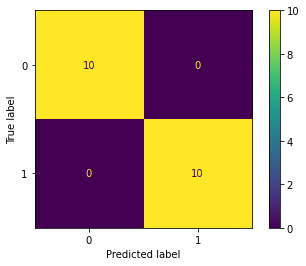

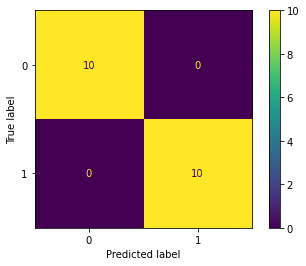

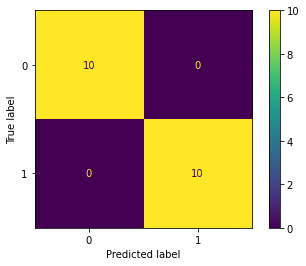

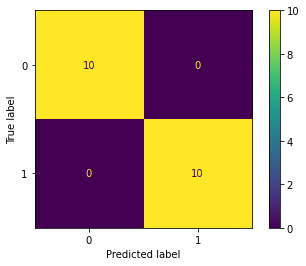

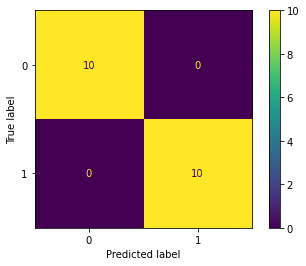

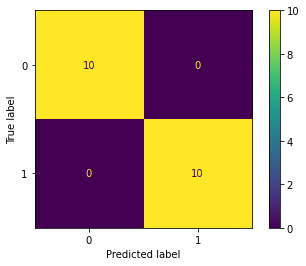

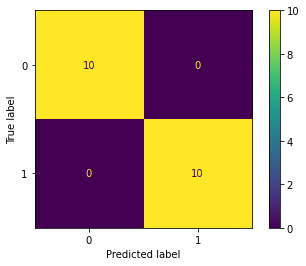

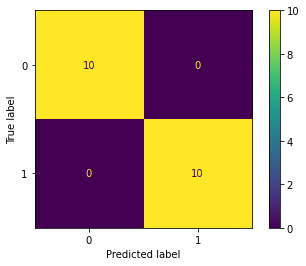

In [19]:
ground_truth = [False, False, True, True, False]
novelty_judgments = []
n_exps = 10

for i in range(n_exps):
    print("========== Experiment %s ==========" % str(i+1))
    
    #feature_idxs = [*range(3,16),*range(22,28)]
    feature_idxs = [*range(3,13),*range(22,28)] # without jitter force
    #feature_idxs = [*range(3,19),*range(22,28)] # with object position
    Xtrain, Ttrain, Xtest, Ttest = make_train_test_data([0,1], crop_len, feature_idxs)
    print()

    model = train_classifier(Xtrain, Ttrain, 2)
    print()

    # check classifier on the test data
    classes, probs = model.use(Xtest)

    # make confusion matrix
    cm = sklearn.metrics.confusion_matrix(Ttest, classes)
    disp = ConfusionMatrixDisplay(cm)
    disp.plot()

    novel_classes, dissimilarities = compare_classes(model, Xtrain.shape[-1]//10)
    novelty_judgments.append(novel_classes)
    
novelty_judgments = np.array(novelty_judgments).reshape(n_exps,-1).T

pred_acc = []
for i in range(2,len(ground_truth)):
    pred_acc.append(np.sum(novelty_judgments[i] == ground_truth[i])/n_exps)
    print(ground_truth[i], novelty_judgments[i], pred_acc[-1])
    
print(pred_acc, np.mean(pred_acc))